# Préparation du Notebook

In [1]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import time

# Importation des bibliothèques pour l'analyse de données
import numpy as np
import pandas as pd
from scipy import stats

# Importation des bibliothèques pour la visualisation de données
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Importation de bibliothèque pour clustering
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.utils import shuffle
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.neighbors import NearestNeighbors

In [3]:
df_analyse = pd.read_csv("df_analyse.csv")

In [4]:
df_analyse

order_purchase_timestamp                customer_unique_id  \
0          2016-10-03 16:56:50  2f64e403852e6893ae37485d5fcacdaf   
1          2016-10-03 21:13:36  61db744d2f835035a5625b59350c6b63   
2          2016-10-03 22:06:03  8d3a54507421dbd2ce0a1d58046826e0   
3          2016-10-03 22:31:31  87776adb449c551e74c13fc34f036105   
4          2016-10-03 22:44:10  7390ed59fa1febbfda31a80b4318c8cb   
...                        ...                               ...   
92749      2018-08-29 12:25:59  7a22d14aa3c3599238509ddca4b93b01   
92750      2018-08-29 14:18:23  5c58de6fb80e93396e2f35642666b693   
92751      2018-08-29 14:18:28  7febafa06d9d8f232a900a2937f04338   
92752      2018-08-29 14:52:00  b701bebbdf478f5500348f03aff62121   
92753      2018-08-29 15:00:37  24ac2b4327e25baf39f2119e4228976a   

       average_installments  average_review_score  recency  frequency  \
0                       1.0                   4.0      699          1   
1                       1.0                   3.0      699          1   
2                       6.0                   1.0      699          1   
3                       4.0                   5.0      699          1   
4                       2.0                   5.0      699          1   
...                     ...                   ...      ...        ...   
92749                   7.0                   1.0        4          1   
92750                   8.0                   5.0        4          1   
92751                   1.0                   5.0        4          1   
92752                   1.0                   3.0        4          1   
92753                   1.0                   5.0        4          1   

       monetary most_frequent_payment_type  \
0         39.09                     boleto   
1         53.73                     boleto   
2        133.46                credit_card   
3         40.95                credit_card   
4        154.57                credit_card   
...         ...                        ...   
92749     73.10                credit_card   
92750    510.96                credit_card   
92751     61.29                    voucher   
92752     33.23                credit_card   
92753     93.75                credit_card   

                        most_frequent_category  
0                               sports_leisure  
1                               sports_leisure  
2                              furniture_decor  
3                                fashion_shoes  
4                                         toys  
...                                        ...  
92749                                     toys  
92750  kitchen_dining_laundry_garden_furniture  
92751                            health_beauty  
92752                           party_supplies  
92753                    computers_accessories  

[92754 rows x 9 columns]

# Selection des features

L'analyse exploratoire a démontré qu'il n'y avait pas de tendance particulière concernant les types de paiements frequemment utilisés. Nous décidons de l'exclure de nos essais. Nous décidons de conserver les catégories frequemment achetées afin de pouvoir, peut être, observer la formation de clustering avec les informations de cette variable.

In [5]:
X = df_analyse.drop(['order_purchase_timestamp', 'customer_unique_id','most_frequent_payment_type'], axis=1)

In [6]:
X

average_installments  average_review_score  recency  frequency  \
0                       1.0                   4.0      699          1   
1                       1.0                   3.0      699          1   
2                       6.0                   1.0      699          1   
3                       4.0                   5.0      699          1   
4                       2.0                   5.0      699          1   
...                     ...                   ...      ...        ...   
92749                   7.0                   1.0        4          1   
92750                   8.0                   5.0        4          1   
92751                   1.0                   5.0        4          1   
92752                   1.0                   3.0        4          1   
92753                   1.0                   5.0        4          1   

       monetary                   most_frequent_category  
0         39.09                           sports_leisure  
1         53.73                           sports_leisure  
2        133.46                          furniture_decor  
3         40.95                            fashion_shoes  
4        154.57                                     toys  
...         ...                                      ...  
92749     73.10                                     toys  
92750    510.96  kitchen_dining_laundry_garden_furniture  
92751     61.29                            health_beauty  
92752     33.23                           party_supplies  
92753     93.75                    computers_accessories  

[92754 rows x 6 columns]

## Transformation des features

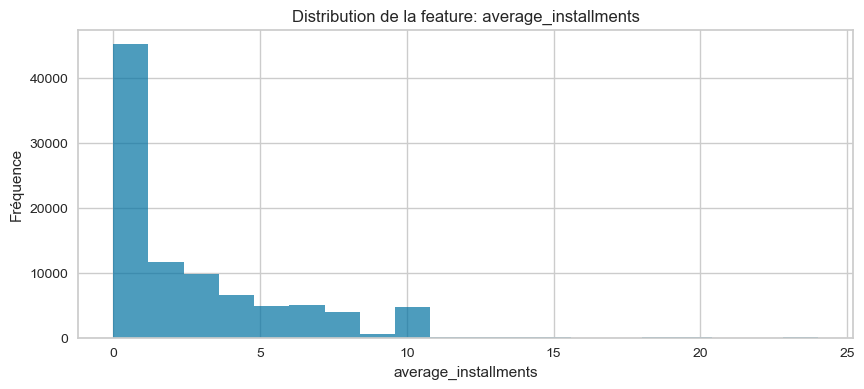

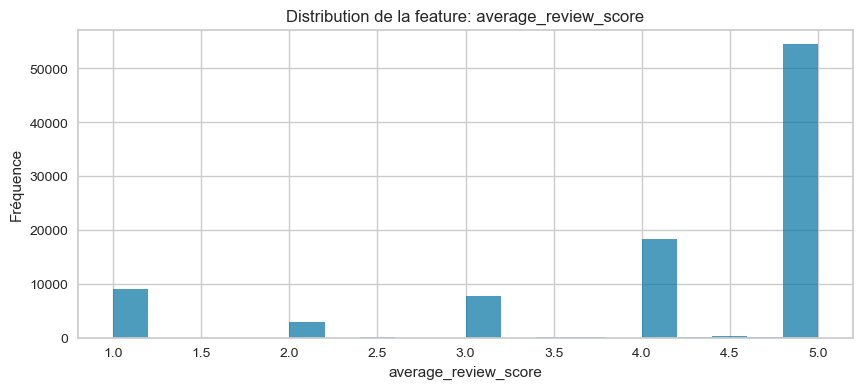

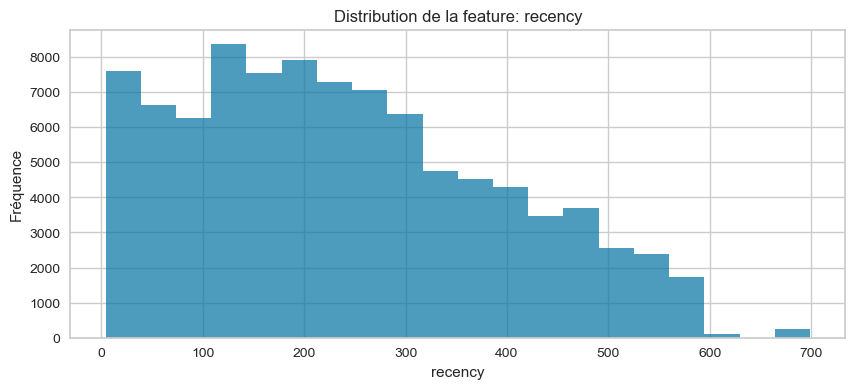

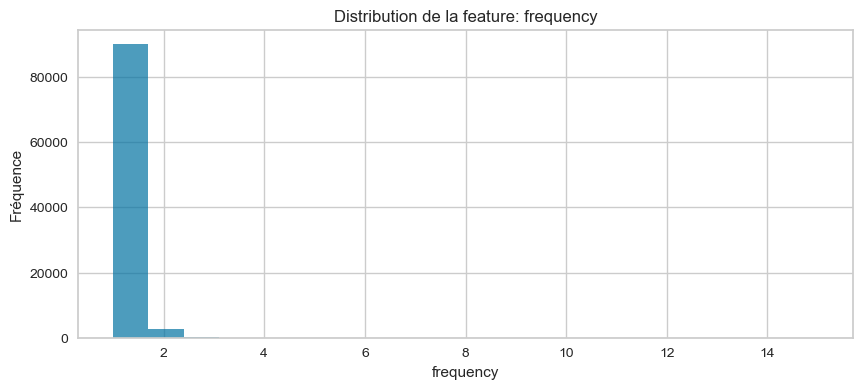

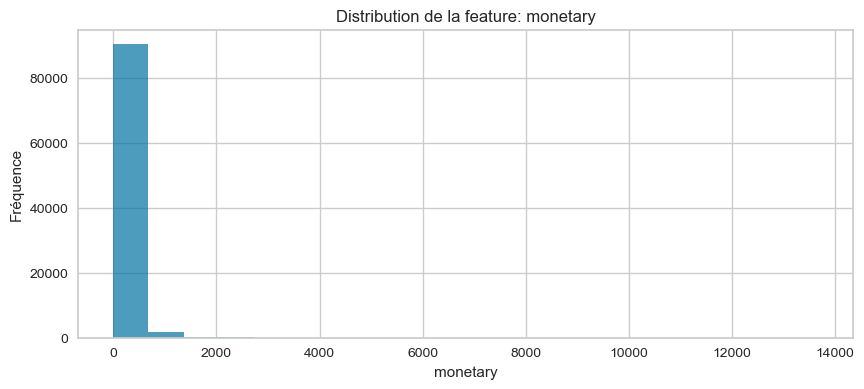

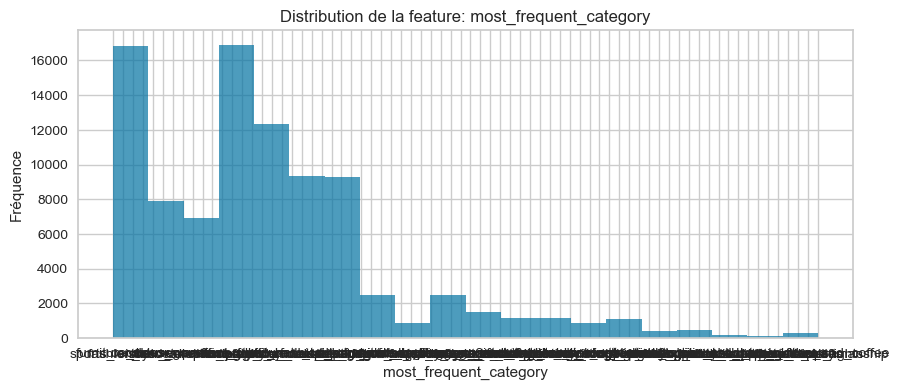

In [7]:
# Visualisation des distributions des features

for column in X.columns:
    plt.figure(figsize=(10, 4))
    plt.hist(X[column], bins=20, alpha=0.7)
    plt.title(f'Distribution de la feature: {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')
    plt.show()

L'observation des distributions de nos features nous ont amené à effectuer une transformation logarythmique sur les colonnes qui présentaient une asymétrie qui pourrait nuir à nos simulations de clustering.

In [8]:
# Transformation logarithmique

X['recency'] = np.log(X['recency'] + 1)
X['monetary'] = np.log(X['monetary'] + 1)
X['frequency'] = np.log(X['frequency'] + 1)

## Standardisation & OneHotEncoder

### Standardisation des variables quantitatives

In [9]:
scaler = MinMaxScaler()

In [10]:
features_to_scale = X.select_dtypes(include=[np.number]).columns
X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

### Encodage de la variable qualitative

In [11]:
encoder = OneHotEncoder(sparse=False)

In [12]:
most_frequent_category = X[['most_frequent_category']]

encoded_features = encoder.fit_transform(most_frequent_category)
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['most_frequent_category']))

X.reset_index(drop=True, inplace=True)
X = pd.concat([X, encoded_features_df], axis=1)

X = X.drop('most_frequent_category', axis=1)

C:\Users\DUBUS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Creation d'un échantillon

In [13]:
X_shuffled = shuffle(X, random_state=42)
X_shuffled.reset_index(drop=True, inplace=True)

sample_size = int(len(X_shuffled) * 0.2)
X_sample = X_shuffled[:sample_size]

# Essai avec RFM (3 features)

In [14]:
X_sample_RFM = X_sample[['recency', 'frequency', 'monetary']].copy()

In [15]:
X_sample_RFM

recency  frequency  monetary
0      0.325689        0.0  0.516012
1      0.430673        0.0  0.474766
2      0.280533        0.0  0.529514
3      0.815299        0.0  0.479851
4      0.919390        0.0  0.519429
...         ...        ...       ...
18545  0.649752        0.0  0.559185
18546  0.954844        0.0  0.508496
18547  0.914156        0.0  0.473795
18548  0.921105        0.0  0.461417
18549  0.686919        0.0  0.449055

[18550 rows x 3 columns]

## KMEANS

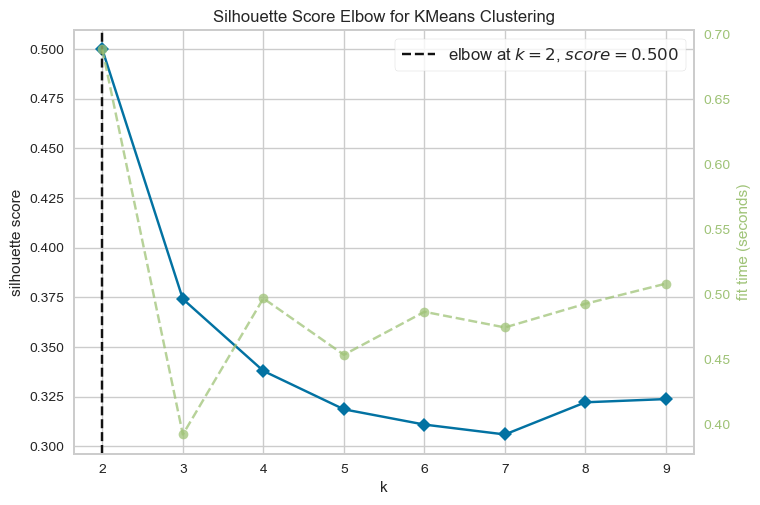

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [16]:
# Graphique visualisation methode du coude et score slhouette

model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

visualizer.fit(X_sample_RFM)
visualizer.show() 

In [17]:
# Calcule des scores silhouettes

silhouette_scores_list = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sample_RFM)
    silhouette_avg = silhouette_score(X_sample_RFM, cluster_labels)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df

n_clusters  silhouette_score
0           2          0.499750
1           3          0.374090
2           4          0.337892
3           5          0.318569
4           6          0.310883
5           7          0.305905
6           8          0.322109
7           9          0.323734

In [18]:
# Modèle Kmeans

start_time_kmeans_rfm = time.time()

kmeans_k2 = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_k2.fit(X_sample_RFM)

end_time_kmeans_rfm = time.time()

execution_time_kmeans_rfm = end_time_kmeans_rfm - start_time_kmeans_rfm
              
labels_k2 = kmeans_k2.labels_
centroids_k2 = kmeans_k2.cluster_centers_

In [19]:
centroids_df = pd.DataFrame(centroids_k2, columns=['Recency', 'Frequency', 'Monetary'])

In [20]:
# Affichage des centroïds

centroids_df

Recency  Frequency  Monetary
0  0.812712   0.005675  0.493427
1  0.476709   0.007185  0.494856

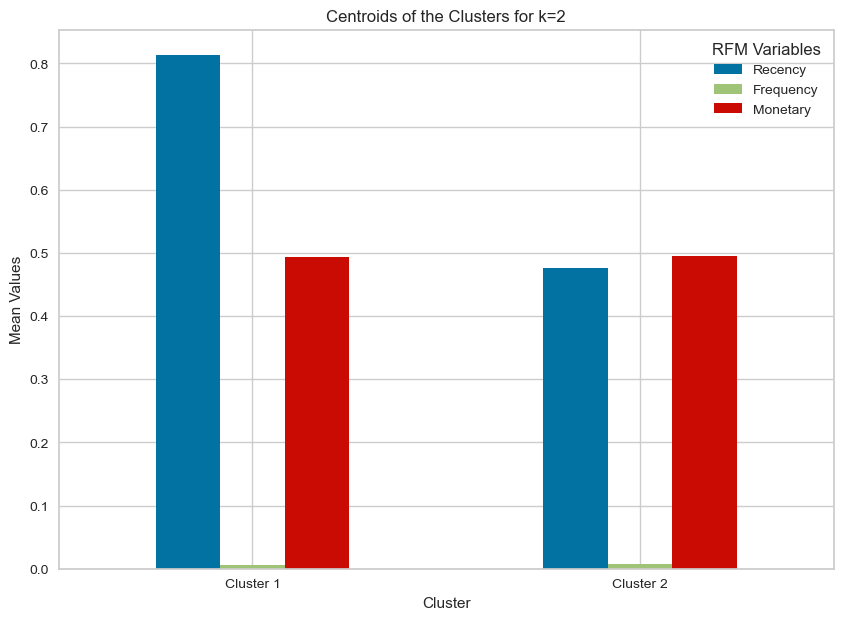

In [21]:
centroids_df.plot(kind='bar', figsize=(10, 7))
plt.title('Centroids of the Clusters for k=2')
plt.ylabel('Mean Values')
plt.xlabel('Cluster')
plt.xticks(np.arange(len(centroids_df)), ['Cluster 1', 'Cluster 2'], rotation=0)
plt.legend(title='RFM Variables')
plt.show()

In [22]:
df_kmeans_k2 = X_sample_RFM.assign(cluster_k2=labels_k2)

In [23]:
# Calcul des moyennes pour chaque cluster

cluster_means_k2 = df_kmeans_k2.groupby('cluster_k2').mean()

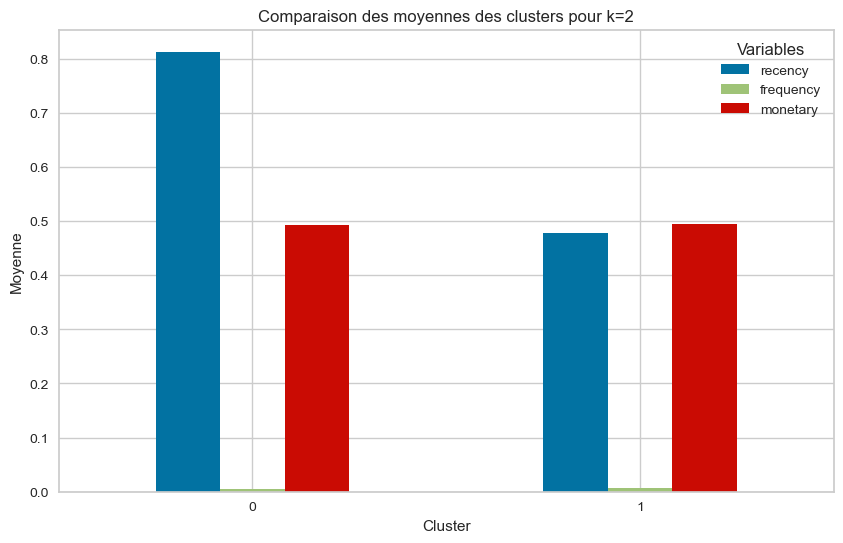

In [24]:
cluster_means_k2.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour k=2')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.show()

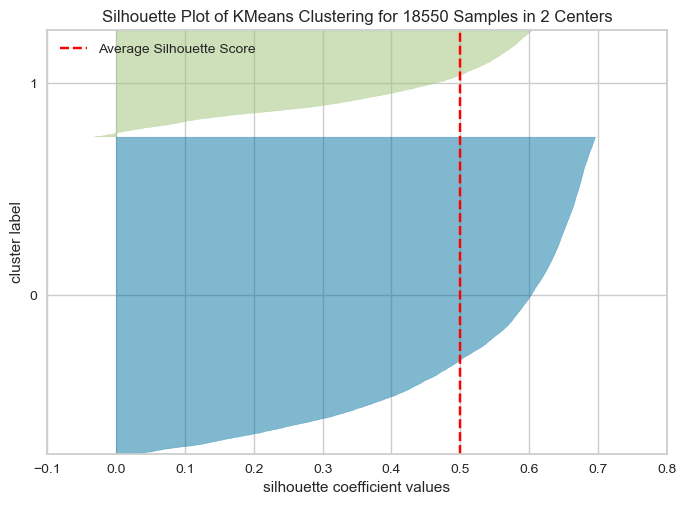

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18550 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
#Visualisation des clusters

model = KMeans(2,n_init=10, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_sample_RFM)
visualizer.show()

In [26]:
# Calcul des scores

davies_bouldin_k2 = davies_bouldin_score(X_sample_RFM, labels_k2)
calinski_harabasz_k2 = calinski_harabasz_score(X_sample_RFM, labels_k2)
silhouette_k2 = silhouette_score(X_sample_RFM, labels_k2)

In [27]:
# Création d'un DataFrame pour les résultats

scores_df = pd.DataFrame({
    'Method': ['KMeans avec k2'],
    'Davies-Bouldin': [davies_bouldin_k2],
    'Calinski-Harabasz': [calinski_harabasz_k2],
    'Silhouette': [silhouette_k2],
    'Execution Time (seconds)': [execution_time_kmeans_rfm]
})

scores_df

Method  Davies-Bouldin  Calinski-Harabasz  Silhouette  \
0  KMeans avec k2        0.784619       20254.524786     0.49975   

   Execution Time (seconds)  
0                  0.358896

## Clustering Hiérarchique

In [28]:
linked = linkage(X_sample_RFM, method='ward')

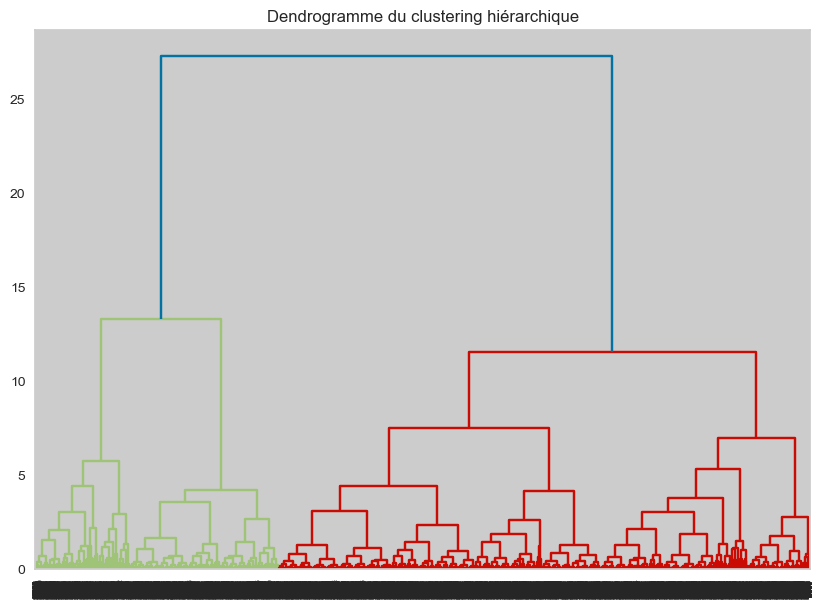

In [29]:
# Dendogramme du Clustering Hiérarchique

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogramme du clustering hiérarchique')
plt.show()

In [30]:
# Modèle Clustering Hiérarchique

start_time_rfm_ch = time.time()

max_distance = 15
clusters = fcluster(linked, max_distance, criterion='distance')

end_time_rfm_ch = time.time()

execution_time_rfm_hierarchical = end_time_rfm_ch - start_time_rfm_ch

X_sample_RFM_with_clusters_ch = X_sample_RFM.copy()
X_sample_RFM_with_clusters_ch['Cluster_Labels'] = clusters

In [31]:
# Calcule des scores silhouettes

silhouette_scores_list = []

for n_clusters in range(2, 10):
    clusters = fcluster(linked, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(X_sample_RFM, clusters)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df_ch = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df_ch

n_clusters  silhouette_score
0           2          0.448800
1           3          0.338879
2           4          0.295909
3           5          0.260236
4           6          0.268447
5           7          0.254984
6           8          0.272422
7           9          0.242603

In [32]:
# Calcule des moyennes pour chaque cluster

cluster_means_hierarchical = X_sample_RFM_with_clusters_ch.groupby('Cluster_Labels').mean()

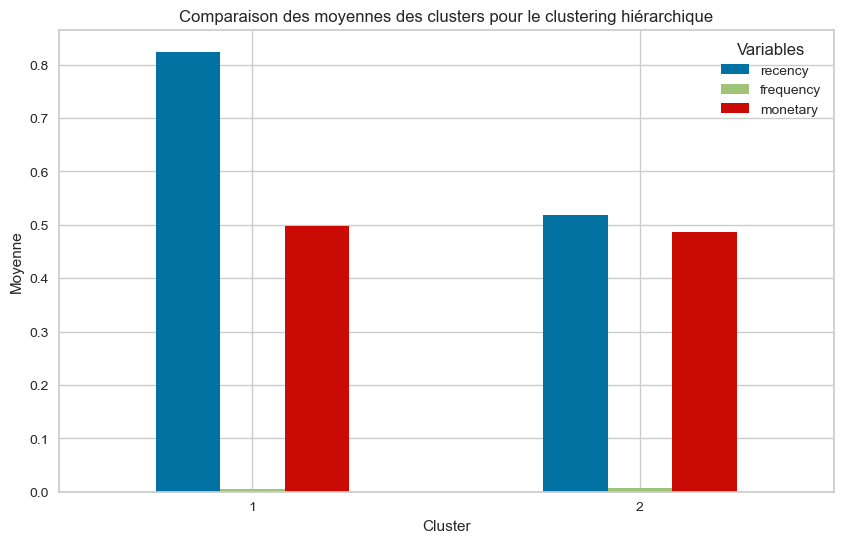

In [33]:
cluster_means_hierarchical.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour le clustering hiérarchique')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.show()

In [34]:
# Utilisation de T-SNE pour visualiser les clusters

tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample_RFM)

hierarchical_labels = fcluster(linked, 2, criterion='maxclust')

tsne_df = pd.DataFrame({'X': X_tsne[:, 0], 'Y': X_tsne[:, 1], 'Cluster': hierarchical_labels})

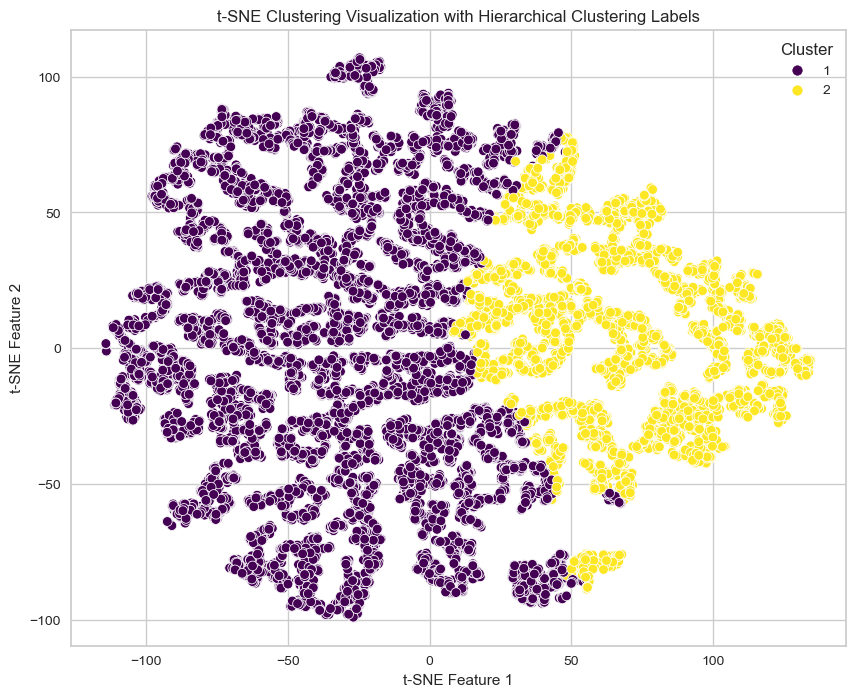

In [35]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=tsne_df, palette='viridis', legend='full')

plt.title('t-SNE Clustering Visualization with Hierarchical Clustering Labels')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

In [36]:
# Calcule des scores et affichage des résultats

clusters_k2 = fcluster(linked, 2, criterion='maxclust')

davies_bouldin_hc = davies_bouldin_score(X_sample_RFM, clusters_k2)
calinski_harabasz_hc = calinski_harabasz_score(X_sample_RFM, clusters_k2)
silhouette_hc = silhouette_score(X_sample_RFM, clusters_k2)

scores_hc_df = pd.DataFrame({
    'Method': ['Hierarchical Clustering k2'],
    'Davies-Bouldin': [davies_bouldin_hc],
    'Calinski-Harabasz': [calinski_harabasz_hc],
    'Silhouette': [silhouette_hc],
    'Execution Time (seconds)': [execution_time_rfm_hierarchical]
})

scores_hc_df

Method  Davies-Bouldin  Calinski-Harabasz  Silhouette  \
0  Hierarchical Clustering k2        0.863327       18183.993914      0.4488   

   Execution Time (seconds)  
0                  0.031854

## DBSCAN

In [37]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_sample_RFM)
distances, indices = neighbors_fit.kneighbors(X_sample_RFM)

In [38]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

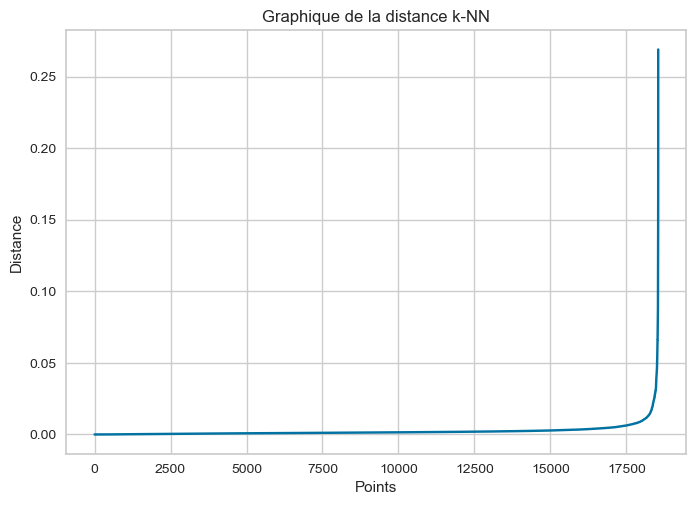

In [39]:
# Graphique de la distance K-NN

plt.plot(distances)
plt.title('Graphique de la distance k-NN')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.show()

In [40]:
# Modèle DBSCAN

eps = 12500
min_samples = 4

start_time_rfm_dbscan = time.time()

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_sample_RFM)

end_time_rfm_dbscan = time.time()

execution_time_rfm_dbscan = end_time_rfm_dbscan - start_time_rfm_dbscan

In [41]:
# Calcule des scores silhouettes

mask = clusters != -1
filtered_X = X_sample_RFM[mask]
filtered_clusters = clusters[mask]

unique_clusters = len(set(filtered_clusters))
num_noise = sum(clusters == -1)

if unique_clusters > 1:
    davies_bouldin_score_val = davies_bouldin_score(filtered_X, filtered_clusters)
    calinski_harabasz_score_val = calinski_harabasz_score(filtered_X, filtered_clusters)
    silhouette_score_val = silhouette_score(filtered_X, filtered_clusters)
else:
    davies_bouldin_score_val = None
    calinski_harabasz_score_val = None
    silhouette_score_val = None
    print("Le score de silhouette ne peut pas être calculé s'il n'y a qu'un seul cluster ou si tous les points sont considérés comme du bruit")

print(f'Nombre de clusters trouvés par DBSCAN (en excluant le bruit) : {unique_clusters}')
print(f'Nombre de points de bruit : {num_noise}')
print(f'Silhouette Score: {silhouette_score_val}')

Le score de silhouette ne peut pas être calculé s'il n'y a qu'un seul cluster ou si tous les points sont considérés comme du bruit
Nombre de clusters trouvés par DBSCAN (en excluant le bruit) : 1
Nombre de points de bruit : 0
Silhouette Score: None


In [42]:
# Calcule des moyennes de chaque clusters

df_dbscan = X_sample_RFM.assign(Cluster_Labels=clusters)

df_dbscan = df_dbscan[df_dbscan['Cluster_Labels'] != -1]

cluster_means_dbscan = df_dbscan.groupby('Cluster_Labels').mean()

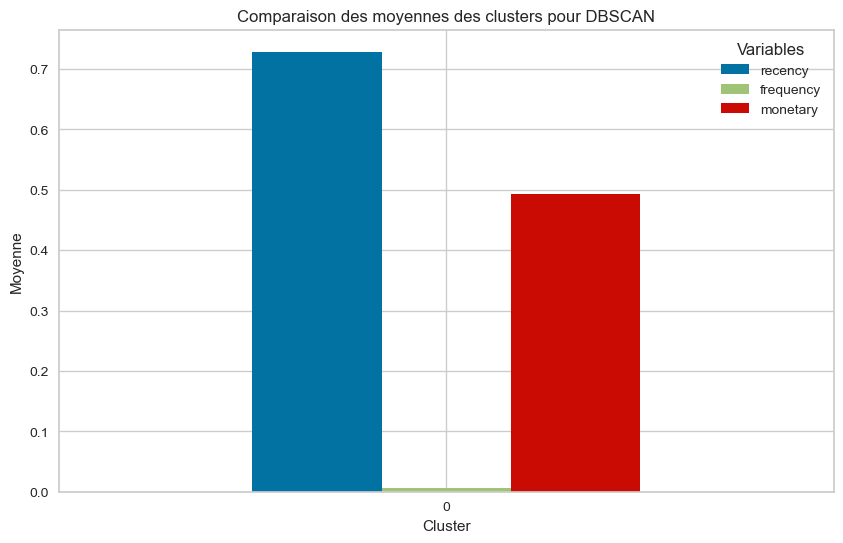

In [43]:
cluster_means_dbscan.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour DBSCAN')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.show()

In [44]:
# Utilisation de T-SNE pour visualiser les clusters

tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)

X_tsne = tsne.fit_transform(X_sample_RFM)
tsne_df = pd.DataFrame({
    'X': X_tsne[:, 0],
    'Y': X_tsne[:, 1],
    'Cluster': clusters
})

tsne_df = tsne_df[tsne_df['Cluster'] != -1]

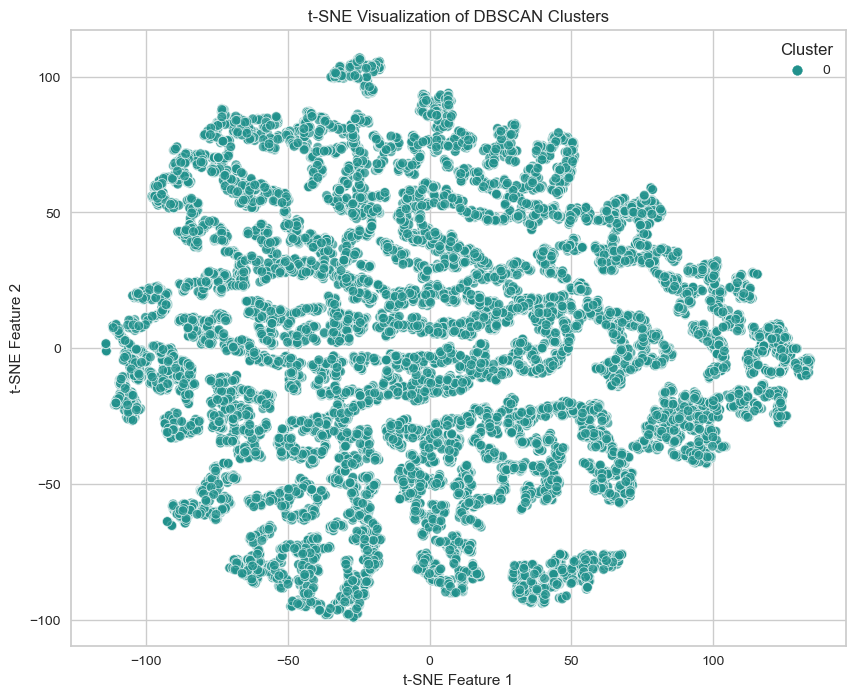

In [45]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=tsne_df, palette='viridis', legend='full', alpha=0.7)

plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()

In [46]:
# Calcule des scores et affichage

scores_dbscan_df = pd.DataFrame({
    'Method': ['DBSCAN'],
    'Davies-Bouldin': [davies_bouldin_score_val],
    'Calinski-Harabasz': [calinski_harabasz_score_val],
    'Silhouette': [silhouette_score_val],
    'Execution Time (seconds)': [execution_time_rfm_dbscan] 
})

scores_dbscan_df

Method Davies-Bouldin Calinski-Harabasz Silhouette  \
0  DBSCAN           None              None       None   

   Execution Time (seconds)  
0                  7.406049

## Conclusion de l'essai

L'analyse RFM, bien que pertinente pour une première segmentation des clients, présente des limites en tant qu'outil unique. Les clusters identifiés par KMeans et le clustering hiérarchique offrent des insights utiles, mais peuvent oversimplifier la diversité des comportements d'achat. DBSCAN, quant à lui, met en évidence le besoin de paramètres plus affinés ou de données supplémentaires pour une segmentation précise.

Il est clair que l'ajout de features complémentaires est nécessaire pour une analyse plus nuancée et efficace. En intégrant des données telles que les préférences de produits et les scores de satisfactions, nous pourrions améliorer notre compréhension des clients et affiner nos stratégies marketing. Cette approche plus holistique est essentielle pour capturer la complexité des comportements d'achat et pour mener des actions marketing ciblées et pertinentes.

# Essai avec RFMS (4 features)

Nous effectuons maintenant l'essai en ajoutant la feature Average_review_score.

In [47]:
X_sample_RFMS = X_sample[['recency', 'frequency', 'monetary', 'average_review_score']].copy()

In [48]:
X_sample_RFMS

recency  frequency  monetary  average_review_score
0      0.325689        0.0  0.516012                  0.50
1      0.430673        0.0  0.474766                  1.00
2      0.280533        0.0  0.529514                  1.00
3      0.815299        0.0  0.479851                  0.50
4      0.919390        0.0  0.519429                  0.50
...         ...        ...       ...                   ...
18545  0.649752        0.0  0.559185                  0.25
18546  0.954844        0.0  0.508496                  1.00
18547  0.914156        0.0  0.473795                  1.00
18548  0.921105        0.0  0.461417                  1.00
18549  0.686919        0.0  0.449055                  0.00

[18550 rows x 4 columns]

## KMEANS

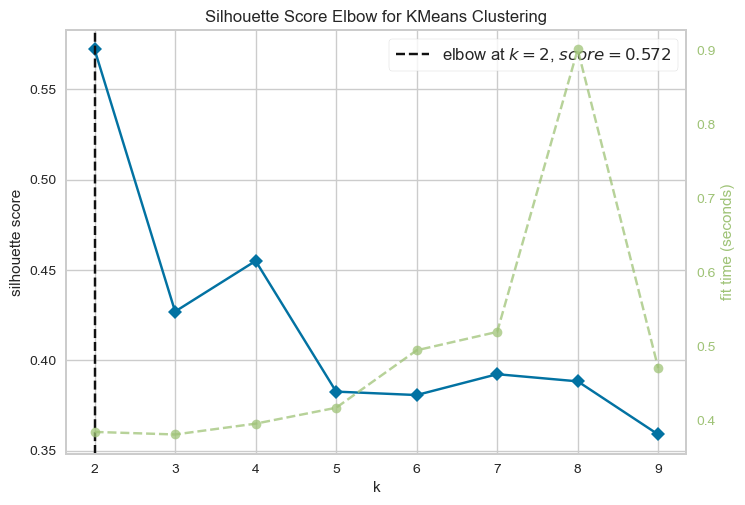

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [49]:
model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

visualizer.fit(X_sample_RFMS)
visualizer.show() 

In [50]:
silhouette_scores_list = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sample_RFMS)
    silhouette_avg = silhouette_score(X_sample_RFMS, cluster_labels)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df

n_clusters  silhouette_score
0           2          0.572001
1           3          0.426946
2           4          0.454959
3           5          0.382613
4           6          0.380716
5           7          0.392255
6           8          0.388294
7           9          0.358890

In [51]:
start_time_kmeans_rfms = time.time()

kmeans_k3 = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_k3.fit(X_sample_RFMS)

end_time_kmeans_rfms = time.time()

execution_time_kmeans_rfms = end_time_kmeans_rfms - start_time_kmeans_rfms
              
labels_k3 = kmeans_k3.labels_
centroids_k3 = kmeans_k3.cluster_centers_

In [52]:
centroids_df = pd.DataFrame(centroids_k3, columns=['Recency', 'Frequency', 'Monetary','average_review_score'])

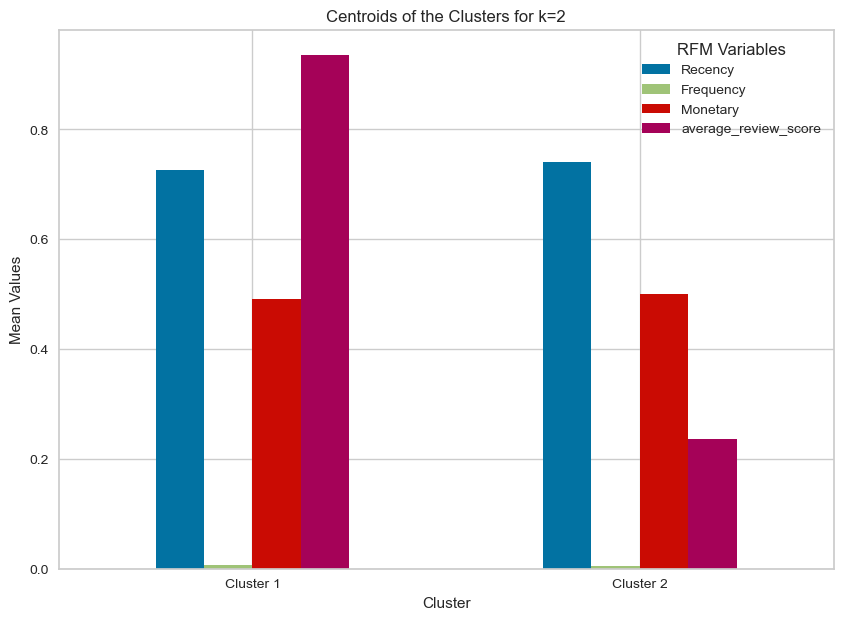

In [53]:
centroids_df.plot(kind='bar', figsize=(10, 7))
plt.title('Centroids of the Clusters for k=2')
plt.ylabel('Mean Values')
plt.xlabel('Cluster')
plt.xticks(np.arange(len(centroids_df)), ['Cluster 1', 'Cluster 2'], rotation=0)
plt.legend(title='RFM Variables')
plt.show()

In [54]:
df_kmeans_k3 = X_sample_RFMS.assign(cluster_k3=labels_k3)

In [55]:
cluster_means_k3 = df_kmeans_k3.groupby('cluster_k3').mean()

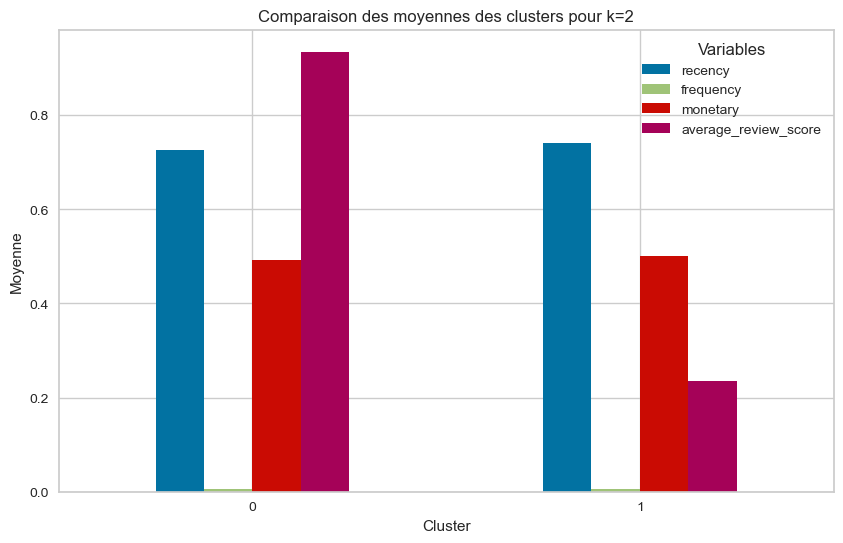

In [56]:
cluster_means_k3.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour k=2')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.show()

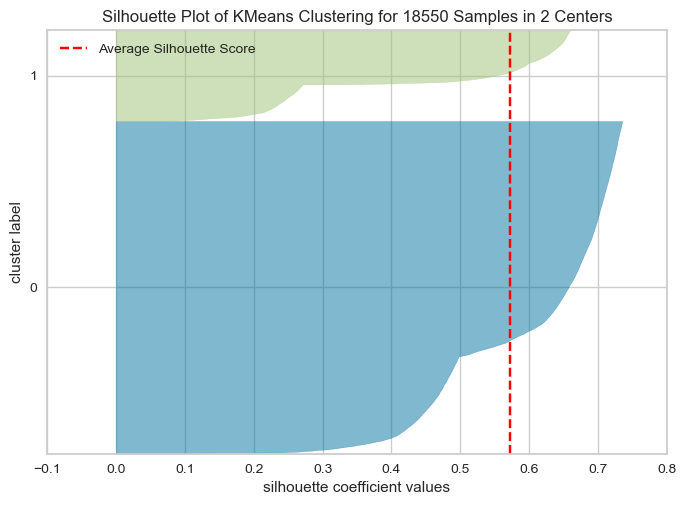

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18550 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [57]:
model = KMeans(2,n_init=10, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_sample_RFMS)
visualizer.show()

In [58]:
davies_bouldin_k3 = davies_bouldin_score(X_sample_RFMS, labels_k3)
calinski_harabasz_k3 = calinski_harabasz_score(X_sample_RFMS, labels_k3)
silhouette_k3 = silhouette_score(X_sample_RFMS, labels_k3)

In [59]:
scores_df = pd.DataFrame({
    'Method': ['KMeans avec k2'],
    'Davies-Bouldin': [davies_bouldin_k3],
    'Calinski-Harabasz': [calinski_harabasz_k3],
    'Silhouette': [silhouette_k3],
    'Execution Time (seconds)': [execution_time_kmeans_rfms]
})

scores_df

Method  Davies-Bouldin  Calinski-Harabasz  Silhouette  \
0  KMeans avec k2        0.708004       24755.122149    0.572001   

   Execution Time (seconds)  
0                  0.361707

## Clustering Hiérarchique

In [60]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_sample_RFMS)
distances, indices = neighbors_fit.kneighbors(X_sample_RFMS)

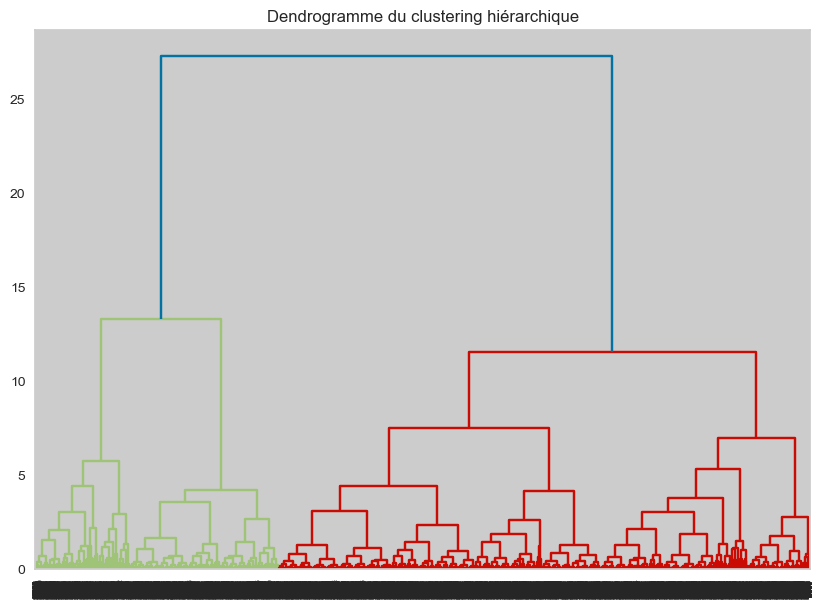

In [61]:
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogramme du clustering hiérarchique')
plt.show()

In [62]:
start_time_rfms_ch = time.time()

max_distance = 15
clusters = fcluster(linked, max_distance, criterion='distance')

end_time_rfms_ch = time.time()

execution_time_rfms_hierarchical = end_time_rfms_ch - start_time_rfms_ch

X_sample_RFMS_with_clusters_ch = X_sample_RFMS.copy()
X_sample_RFMS_with_clusters_ch['Cluster_Labels'] = clusters

In [63]:
silhouette_scores_list = []

for n_clusters in range(2, 10):
    clusters = fcluster(linked, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(X_sample_RFMS, clusters)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df_ch = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df_ch

n_clusters  silhouette_score
0           2          0.221982
1           3          0.123089
2           4          0.103832
3           5          0.071885
4           6          0.077873
5           7          0.064596
6           8          0.069838
7           9          0.064299

In [64]:
cluster_means_hierarchical = X_sample_RFMS_with_clusters_ch.groupby('Cluster_Labels').mean()

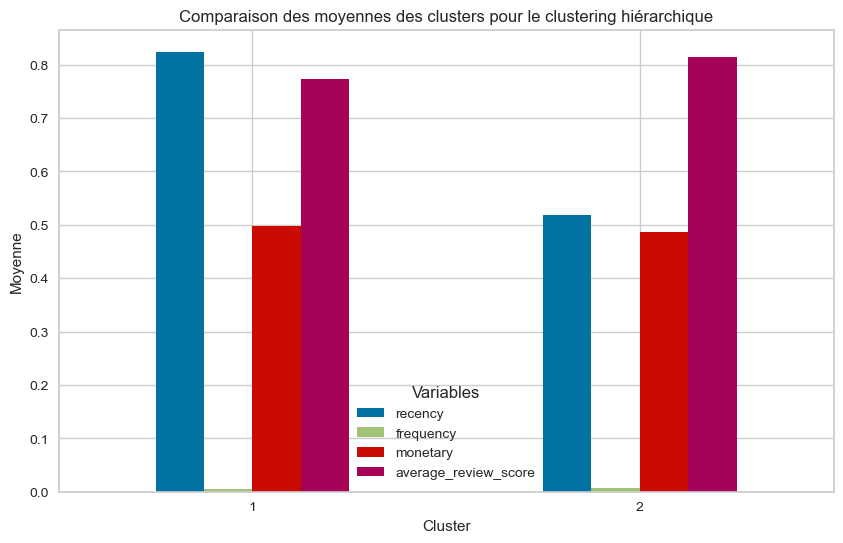

In [65]:
cluster_means_hierarchical.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour le clustering hiérarchique')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.show()

In [66]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample_RFMS)

hierarchical_labels = fcluster(linked, 2, criterion='maxclust')

tsne_df = pd.DataFrame({'X': X_tsne[:, 0], 'Y': X_tsne[:, 1], 'Cluster': hierarchical_labels})

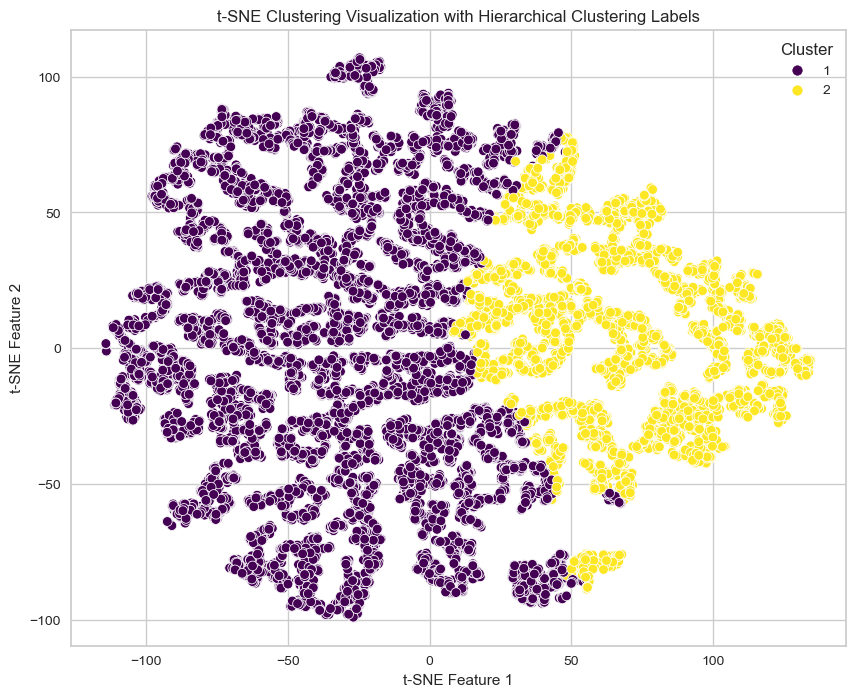

In [67]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=tsne_df, palette='viridis', legend='full')

plt.title('t-SNE Clustering Visualization with Hierarchical Clustering Labels')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

In [68]:
clusters_k3 = fcluster(linked, 2, criterion='maxclust')

davies_bouldin_hc = davies_bouldin_score(X_sample_RFMS, clusters_k3)
calinski_harabasz_hc = calinski_harabasz_score(X_sample_RFMS, clusters_k3)
silhouette_hc = silhouette_score(X_sample_RFMS, clusters_k3)

scores_hc_df = pd.DataFrame({
    'Method': ['Hierarchical Clustering k3'],
    'Davies-Bouldin': [davies_bouldin_hc],
    'Calinski-Harabasz': [calinski_harabasz_hc],
    'Silhouette': [silhouette_hc],
    'Execution Time (seconds)': [execution_time_rfm_hierarchical]
})

scores_hc_df

Method  Davies-Bouldin  Calinski-Harabasz  Silhouette  \
0  Hierarchical Clustering k3        0.863327       18183.993914      0.4488   

   Execution Time (seconds)  
0                  0.031854

## DBSCAN

In [69]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_sample_RFMS)
distances, indices = neighbors_fit.kneighbors(X_sample_RFMS)

In [70]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

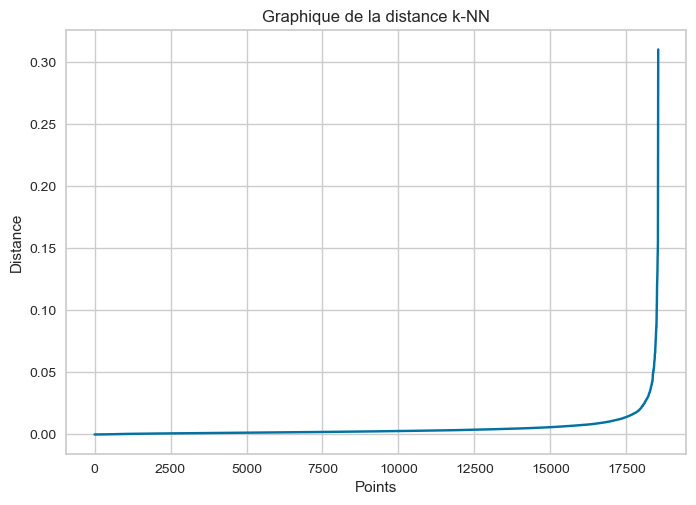

In [71]:
plt.plot(distances)
plt.title('Graphique de la distance k-NN')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.show()

In [72]:
eps = 7500
min_samples = 5

start_time_rfms_dbscan = time.time()

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_sample_RFMS)

end_time_rfms_dbscan = time.time()

execution_time_rfms_dbscan = end_time_rfms_dbscan - start_time_rfms_dbscan

In [73]:
mask = clusters != -1
filtered_X = X_sample_RFMS[mask]
filtered_clusters = clusters[mask]

unique_clusters = len(set(filtered_clusters))
num_noise = sum(clusters == -1)

if unique_clusters > 1:
    davies_bouldin_score_val = davies_bouldin_score(filtered_X, filtered_clusters)
    calinski_harabasz_score_val = calinski_harabasz_score(filtered_X, filtered_clusters)
    silhouette_score_val = silhouette_score(filtered_X, filtered_clusters)
else:
    davies_bouldin_score_val = None
    calinski_harabasz_score_val = None
    silhouette_score_val = None
    print("Le score de silhouette ne peut pas être calculé s'il n'y a qu'un seul cluster ou si tous les points sont considérés comme du bruit")

print(f'Nombre de clusters trouvés par DBSCAN (en excluant le bruit) : {unique_clusters}')
print(f'Nombre de points de bruit : {num_noise}')
print(f'Silhouette Score: {silhouette_score_val}')

Le score de silhouette ne peut pas être calculé s'il n'y a qu'un seul cluster ou si tous les points sont considérés comme du bruit
Nombre de clusters trouvés par DBSCAN (en excluant le bruit) : 1
Nombre de points de bruit : 0
Silhouette Score: None


In [74]:
df_dbscan = X_sample_RFMS.assign(Cluster_Labels=clusters)

df_dbscan = df_dbscan[df_dbscan['Cluster_Labels'] != -1]

cluster_means_dbscan = df_dbscan.groupby('Cluster_Labels').mean()

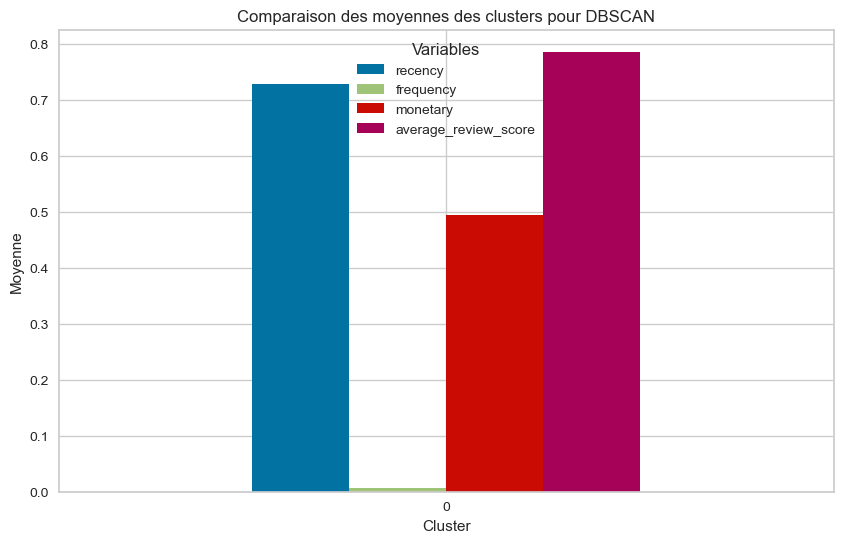

In [75]:
cluster_means_dbscan.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour DBSCAN')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.show()

In [76]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)

X_tsne = tsne.fit_transform(X_sample_RFMS)
tsne_df = pd.DataFrame({
    'X': X_tsne[:, 0],
    'Y': X_tsne[:, 1],
    'Cluster': clusters
})

tsne_df = tsne_df[tsne_df['Cluster'] != -1]

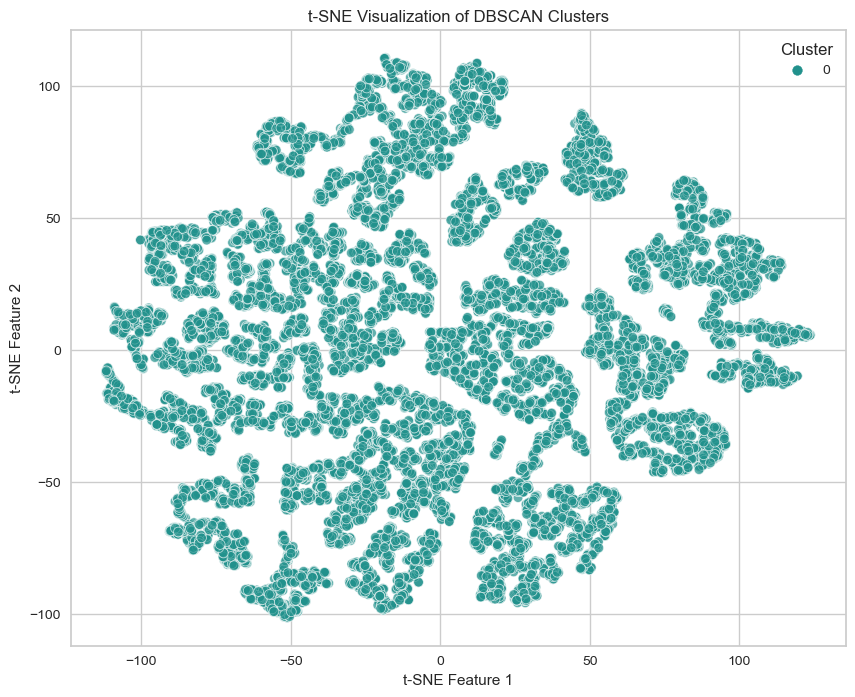

In [77]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=tsne_df, palette='viridis', legend='full', alpha=0.7)

plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()

In [78]:
scores_dbscan_df = pd.DataFrame({
    'Method': ['DBSCAN'],
    'Davies-Bouldin': [davies_bouldin_score_val],
    'Calinski-Harabasz': [calinski_harabasz_score_val],
    'Silhouette': [silhouette_score_val],
    'Execution Time (seconds)': [execution_time_rfm_dbscan] 
})

scores_dbscan_df

Method Davies-Bouldin Calinski-Harabasz Silhouette  \
0  DBSCAN           None              None       None   

   Execution Time (seconds)  
0                  7.406049

## Conclusion de l'essai

L'ajout de la note moyenne des avis a amélioré la segmentation KMeans, avec k=2 montrant le meilleur score de silhouette. Néanmoins, k=4 émerge comme une option intéressante, suggérant une segmentation plus fine. Cela indique que l'intégration de données supplémentaires peut révéler des insights plus profonds sur les clients.

Pour le clustering hiérarchique, l'apport de la note moyenne des avis n'a pas significativement amélioré la segmentation, ce qui pourrait nécessiter r un réajustement des paramètres ol'exploration d'autres variables.

DBSCAN, en revanche, n'a pas performé avec l'ensemble de données enrichi, indiquant un besoin de réévaluation des paramètres ou de l'ajout d'autres features.

Nous continuerons à tester l'ajout de nouvelles variables pour voir si cela améliore davantage les performances de KMeans et pour évaluer leur impact sur les autres méthodes de clustering.

# Essai avec RFMSI (5 features)

Nous effectuons maintenant l'essai en ajoutant la feature Average_review_score et average_installments

In [79]:
X_sample_RFMSI = X_sample[['recency', 'frequency', 'monetary','average_review_score', 'average_installments']].copy()

In [80]:
X_sample_RFMSI

recency  frequency  monetary  average_review_score  \
0      0.325689        0.0  0.516012                  0.50   
1      0.430673        0.0  0.474766                  1.00   
2      0.280533        0.0  0.529514                  1.00   
3      0.815299        0.0  0.479851                  0.50   
4      0.919390        0.0  0.519429                  0.50   
...         ...        ...       ...                   ...   
18545  0.649752        0.0  0.559185                  0.25   
18546  0.954844        0.0  0.508496                  1.00   
18547  0.914156        0.0  0.473795                  1.00   
18548  0.921105        0.0  0.461417                  1.00   
18549  0.686919        0.0  0.449055                  0.00   

       average_installments  
0                  0.208333  
1                  0.041667  
2                  0.041667  
3                  0.041667  
4                  0.500000  
...                     ...  
18545              0.083333  
18546              0.041667  
18547              0.083333  
18548              0.041667  
18549              0.125000  

[18550 rows x 5 columns]

## KMEANS

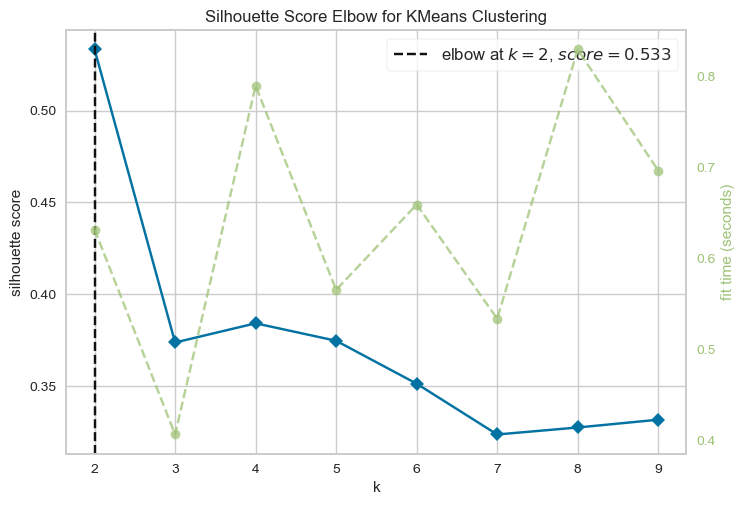

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [81]:
model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

visualizer.fit(X_sample_RFMSI)
visualizer.show() 

In [82]:
silhouette_scores_list = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sample_RFMSI)
    silhouette_avg = silhouette_score(X_sample_RFMSI, cluster_labels)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df

n_clusters  silhouette_score
0           2          0.533235
1           3          0.373774
2           4          0.384209
3           5          0.374705
4           6          0.351348
5           7          0.323714
6           8          0.327514
7           9          0.331753

In [83]:
start_time_kmeans_rfmsi = time.time()

kmeans_k4 = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_k4.fit(X_sample_RFMSI)

end_time_kmeans_rfmsi = time.time()

execution_time_kmeans_rfmsi = end_time_kmeans_rfmsi - start_time_kmeans_rfmsi
              
labels_k4 = kmeans_k4.labels_
centroids_k4 = kmeans_k4.cluster_centers_

In [84]:
centroids_df = pd.DataFrame(centroids_k4, columns=['Recency', 'Frequency', 'Monetary','average_review_score','average_installments'])

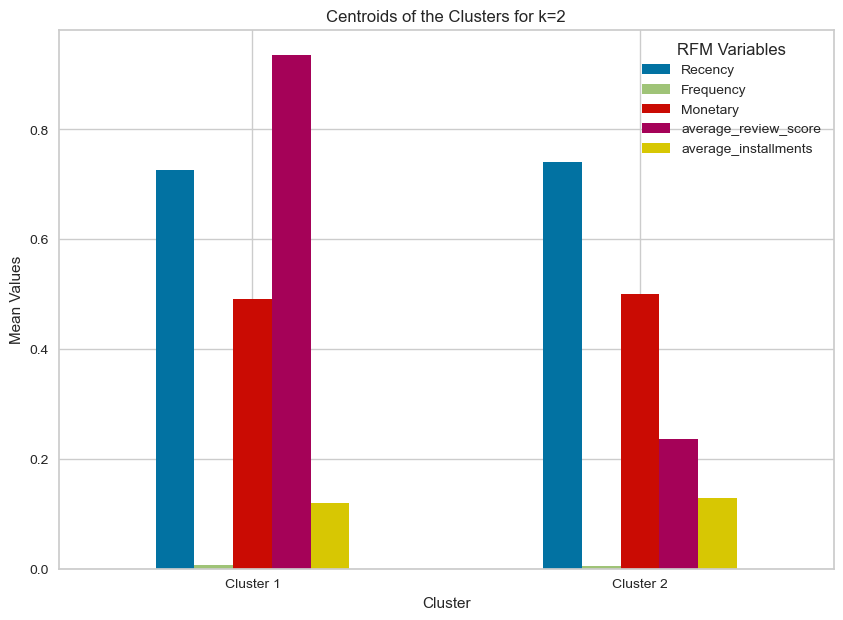

In [85]:
centroids_df.plot(kind='bar', figsize=(10, 7))
plt.title('Centroids of the Clusters for k=2')
plt.ylabel('Mean Values')
plt.xlabel('Cluster')
plt.xticks(np.arange(len(centroids_df)), ['Cluster 1', 'Cluster 2'], rotation=0)
plt.legend(title='RFM Variables')
plt.show()

In [86]:
df_kmeans_k4 = X_sample_RFMSI.assign(cluster_k4=labels_k4)

In [87]:
cluster_means_k4 = df_kmeans_k4.groupby('cluster_k4').mean()

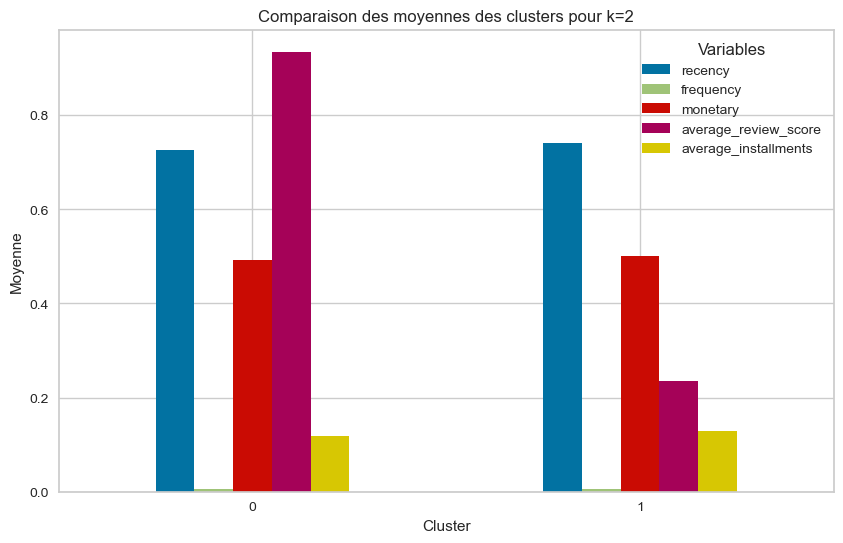

In [88]:
cluster_means_k4.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour k=2')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.show()

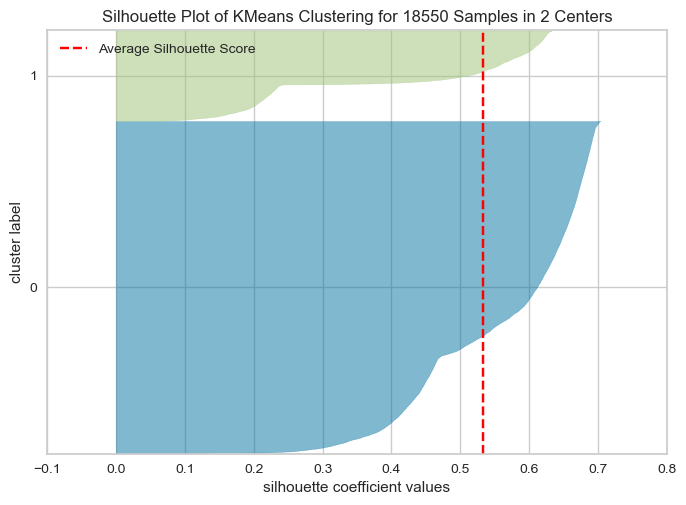

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18550 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [89]:
model = KMeans(2,n_init=10, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_sample_RFMSI)
visualizer.show()

In [90]:
davies_bouldin_k4 = davies_bouldin_score(X_sample_RFMSI, labels_k4)
calinski_harabasz_k4 = calinski_harabasz_score(X_sample_RFMSI, labels_k4)
silhouette_k4 = silhouette_score(X_sample_RFMSI, labels_k4)

In [91]:
scores_df = pd.DataFrame({
    'Method': ['KMeans avec k2'],
    'Davies-Bouldin': [davies_bouldin_k4],
    'Calinski-Harabasz': [calinski_harabasz_k4],
    'Silhouette': [silhouette_k4],
    'Execution Time (seconds)': [execution_time_kmeans_rfmsi]
})

scores_df

Method  Davies-Bouldin  Calinski-Harabasz  Silhouette  \
0  KMeans avec k2        0.778566       20521.614105    0.533235   

   Execution Time (seconds)  
0                  0.387846

## Clustering Hiérarchique

In [92]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_sample_RFMSI)
distances, indices = neighbors_fit.kneighbors(X_sample_RFMSI)

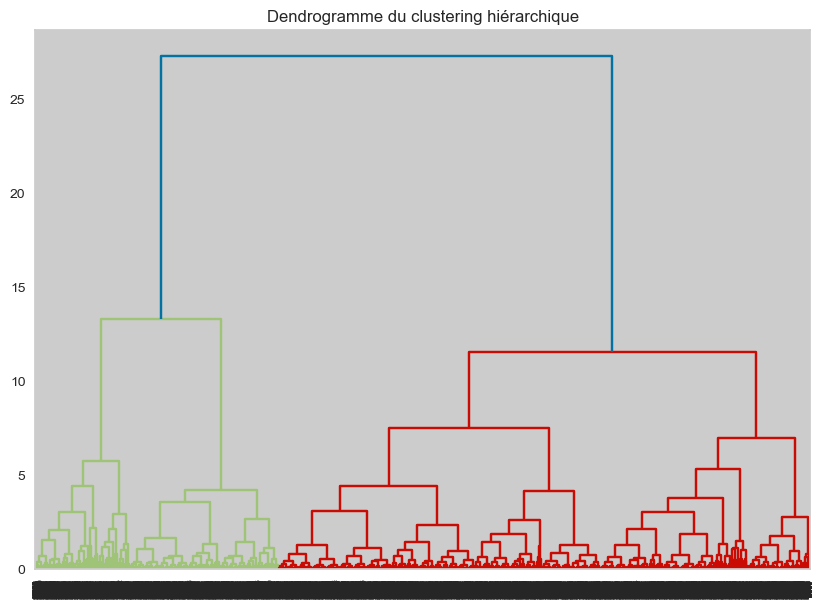

In [93]:
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogramme du clustering hiérarchique')
plt.show()

In [94]:
start_time_rfmsi_ch = time.time()

max_distance = 15
clusters = fcluster(linked, max_distance, criterion='distance')

end_time_rfmsi_ch = time.time()

execution_time_rfmsi_hierarchical = end_time_rfmsi_ch - start_time_rfmsi_ch

X_sample_RFMSI_with_clusters_ch = X_sample_RFMSI.copy()
X_sample_RFMSI_with_clusters_ch['Cluster_Labels'] = clusters

In [95]:
silhouette_scores_list = []

for n_clusters in range(2, 10):
    clusters = fcluster(linked, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(X_sample_RFMSI, clusters)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df_ch = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df_ch

n_clusters  silhouette_score
0           2          0.191583
1           3          0.094894
2           4          0.088876
3           5          0.051478
4           6          0.054251
5           7          0.042401
6           8          0.046739
7           9          0.039749

In [96]:
cluster_means_hierarchical = X_sample_RFMSI_with_clusters_ch.groupby('Cluster_Labels').mean()

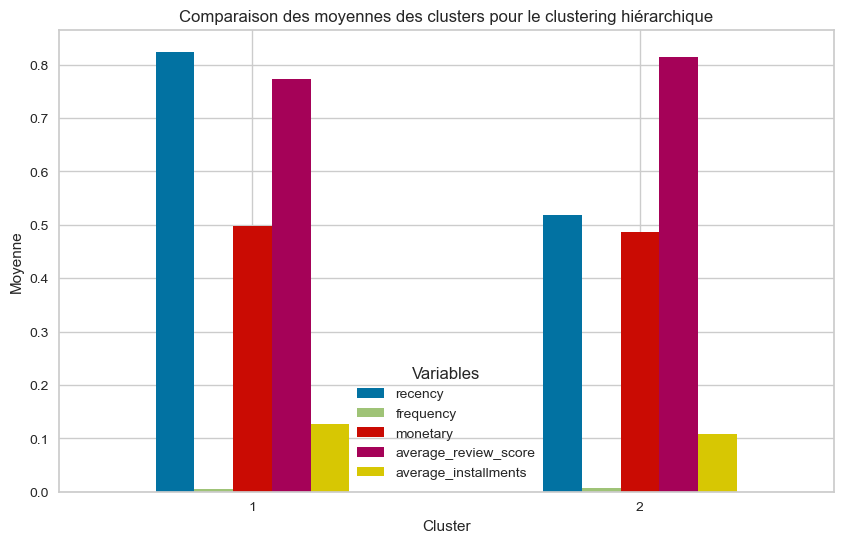

In [97]:
cluster_means_hierarchical.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour le clustering hiérarchique')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.show()

In [124]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample_RFMSI)

hierarchical_labels = fcluster(linked, 2, criterion='maxclust')

tsne_df = pd.DataFrame({'X': X_tsne[:, 0], 'Y': X_tsne[:, 1], 'Cluster': hierarchical_labels})

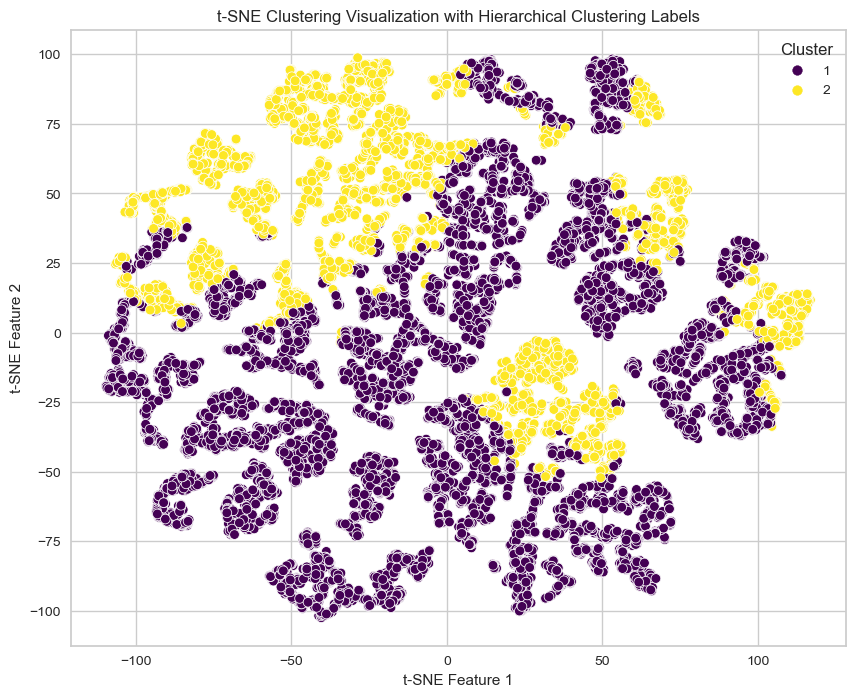

In [125]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=tsne_df, palette='viridis', legend='full')

plt.title('t-SNE Clustering Visualization with Hierarchical Clustering Labels')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

In [100]:
clusters_k4 = fcluster(linked, 2, criterion='maxclust')

davies_bouldin_hc = davies_bouldin_score(X_sample_RFMSI, clusters_k4)
calinski_harabasz_hc = calinski_harabasz_score(X_sample_RFMSI, clusters_k4)
silhouette_hc = silhouette_score(X_sample_RFMSI, clusters_k4)

scores_hc_df = pd.DataFrame({
    'Method': ['Hierarchical Clustering k2'],
    'Davies-Bouldin': [davies_bouldin_hc],
    'Calinski-Harabasz': [calinski_harabasz_hc],
    'Silhouette': [silhouette_hc],
    'Execution Time (seconds)': [execution_time_rfmsi_hierarchical]
})

scores_hc_df

Method  Davies-Bouldin  Calinski-Harabasz  Silhouette  \
0  Hierarchical Clustering k2        2.049041        2805.268539    0.191583   

   Execution Time (seconds)  
0                  0.029314

## DBSCAN

In [101]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_sample_RFMSI)
distances, indices = neighbors_fit.kneighbors(X_sample_RFMSI)

In [102]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

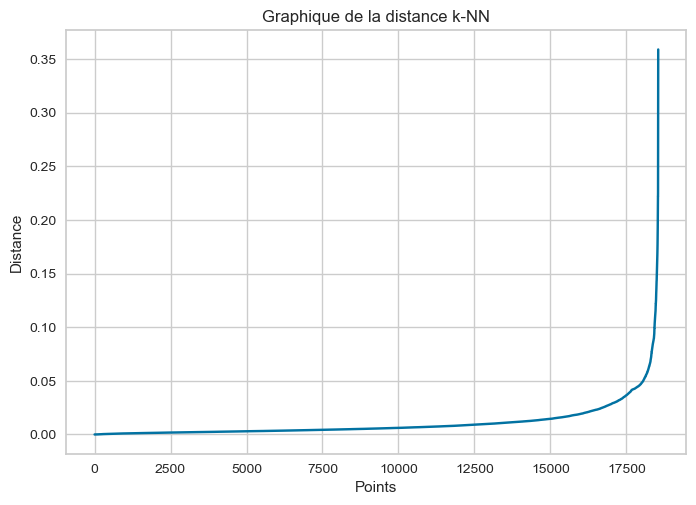

In [103]:
plt.plot(distances)
plt.title('Graphique de la distance k-NN')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.show()

In [126]:
eps = 4000
min_samples = 5

start_time_rfmsi_dbscan = time.time()

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_sample_RFMSI)

end_time_rfmsi_dbscan = time.time()

execution_time_rfmsi_dbscan = end_time_rfmsi_dbscan - start_time_rfmsi_dbscan

In [127]:
mask = clusters != -1
filtered_X = X_sample_RFMSI[mask]
filtered_clusters = clusters[mask]

unique_clusters = len(set(filtered_clusters))
num_noise = sum(clusters == -1)

if unique_clusters > 1:
    davies_bouldin_score_val = davies_bouldin_score(filtered_X, filtered_clusters)
    calinski_harabasz_score_val = calinski_harabasz_score(filtered_X, filtered_clusters)
    silhouette_score_val = silhouette_score(filtered_X, filtered_clusters)
else:
    davies_bouldin_score_val = None
    calinski_harabasz_score_val = None
    silhouette_score_val = None
    print("Le score de silhouette ne peut pas être calculé s'il n'y a qu'un seul cluster ou si tous les points sont considérés comme du bruit")

print(f'Nombre de clusters trouvés par DBSCAN (en excluant le bruit) : {unique_clusters}')
print(f'Nombre de points de bruit : {num_noise}')
print(f'Silhouette Score: {silhouette_score_val}')

Le score de silhouette ne peut pas être calculé s'il n'y a qu'un seul cluster ou si tous les points sont considérés comme du bruit
Nombre de clusters trouvés par DBSCAN (en excluant le bruit) : 1
Nombre de points de bruit : 0
Silhouette Score: None


In [128]:
df_dbscan = X_sample_RFMSI.assign(Cluster_Labels=clusters)

df_dbscan = df_dbscan[df_dbscan['Cluster_Labels'] != -1]

cluster_means_dbscan = df_dbscan.groupby('Cluster_Labels').mean()

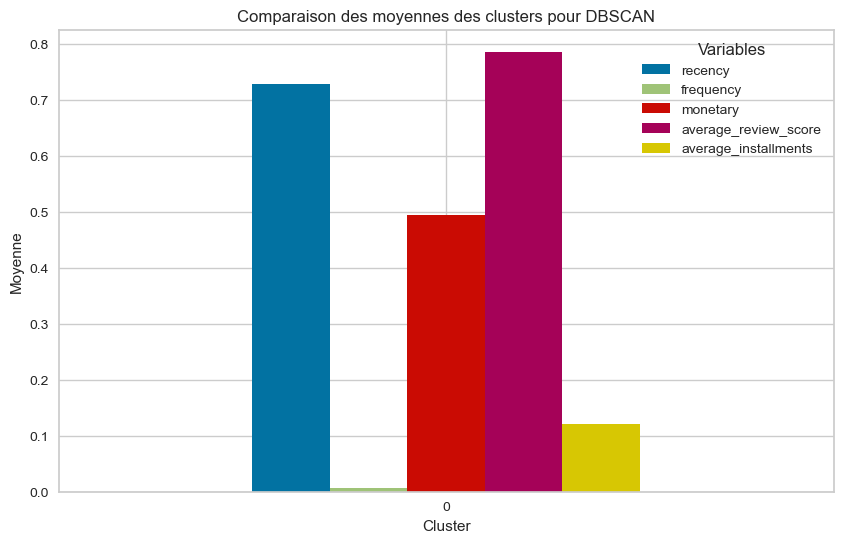

In [129]:
cluster_means_dbscan.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour DBSCAN')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.show()

In [130]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)

X_tsne = tsne.fit_transform(X_sample_RFMSI)
tsne_df = pd.DataFrame({
    'X': X_tsne[:, 0],
    'Y': X_tsne[:, 1],
    'Cluster': clusters
})

tsne_df = tsne_df[tsne_df['Cluster'] != -1]

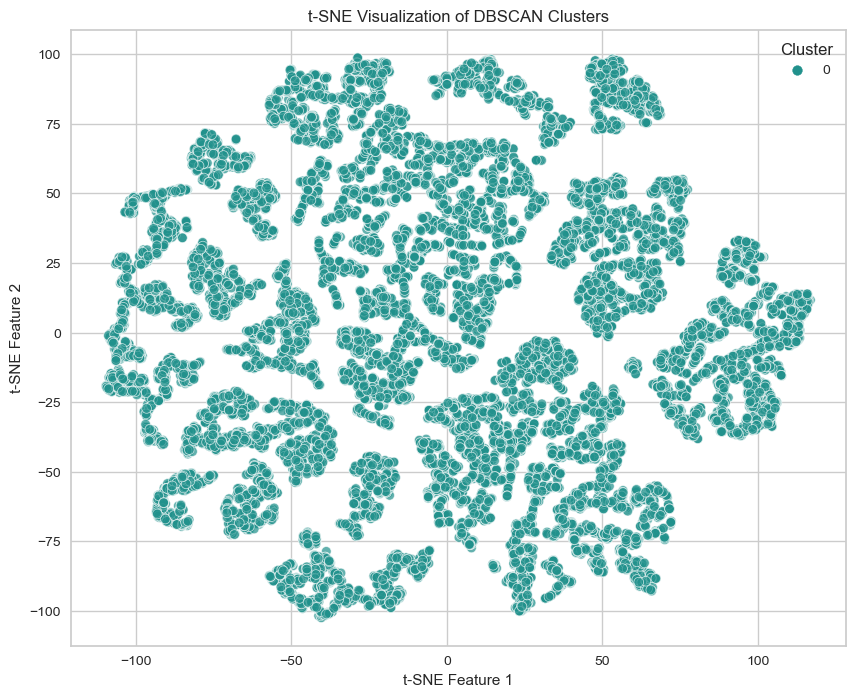

In [131]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=tsne_df, palette='viridis', legend='full', alpha=0.7)

plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()

In [132]:
scores_dbscan_df = pd.DataFrame({
    'Method': ['DBSCAN'],
    'Davies-Bouldin': [davies_bouldin_score_val],
    'Calinski-Harabasz': [calinski_harabasz_score_val],
    'Silhouette': [silhouette_score_val],
    'Execution Time (seconds)': [execution_time_rfm_dbscan] 
})

scores_dbscan_df

Method Davies-Bouldin Calinski-Harabasz Silhouette  \
0  DBSCAN           None              None       None   

   Execution Time (seconds)  
0                  7.406049

## Conclusion de l'essai

L'ajout de la variable 'average_installments' aux données RFM et à la note moyenne des avis n'a pas amélioré les performances de segmentation pour KMeans, avec une baisse du score de silhouette pour k=2 et k=4. Cela suggère que cette variable supplémentaire n'apporte pas de valeur discriminante significative dans le contexte actuel.  

Pour le clustering hiérarchique, l'introduction de 'average_installments' a également compliqué la segmentation, indiquant une moins bonne adéquation avec cette méthode.  

DBSCAN n'a pas réussi à identifier des clusters pertinents.   

Dans nos prochains essais, nous intégrerons une variable catégorielle et examinerons l'ensemble du jeu de données pour évaluer l'impact sur les résultats de segmentation.

# Essai avec l'ensemble des features

In [111]:
X_sample

average_installments  average_review_score   recency  frequency  \
0                  0.208333                  0.50  0.325689        0.0   
1                  0.041667                  1.00  0.430673        0.0   
2                  0.041667                  1.00  0.280533        0.0   
3                  0.041667                  0.50  0.815299        0.0   
4                  0.500000                  0.50  0.919390        0.0   
...                     ...                   ...       ...        ...   
18545              0.083333                  0.25  0.649752        0.0   
18546              0.041667                  1.00  0.954844        0.0   
18547              0.083333                  1.00  0.914156        0.0   
18548              0.041667                  1.00  0.921105        0.0   
18549              0.125000                  0.00  0.686919        0.0   

       monetary  most_frequent_category_agro_industry_and_commerce  \
0      0.516012                                                0.0   
1      0.474766                                                0.0   
2      0.529514                                                0.0   
3      0.479851                                                0.0   
4      0.519429                                                0.0   
...         ...                                                ...   
18545  0.559185                                                0.0   
18546  0.508496                                                0.0   
18547  0.473795                                                0.0   
18548  0.461417                                                0.0   
18549  0.449055                                                0.0   

       most_frequent_category_air_conditioning  most_frequent_category_art  \
0                                          0.0                         0.0   
1                                          0.0                         0.0   
2                                          0.0                         0.0   
3                                          0.0                         0.0   
4                                          0.0                         0.0   
...                                        ...                         ...   
18545                                      0.0                         0.0   
18546                                      0.0                         0.0   
18547                                      0.0                         0.0   
18548                                      0.0                         0.0   
18549                                      0.0                         0.0   

       most_frequent_category_arts_and_craftmanship  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
...                                             ...   
18545                                           0.0   
18546                                           0.0   
18547                                           0.0   
18548                                           0.0   
18549                                           0.0   

       most_frequent_category_audio  ...  \
0                               0.0  ...   
1                               0.0  ...   
2                               0.0  ...   
3                               0.0  ...   
4                               0.0  ...   
...                             ...  ...   
18545                           0.0  ...   
18546                           0.0  ...   
18547                           0.0  ...   
18548                           0.0  ...   
18549                           0.0  ...   

       most_frequent_category_signaling_and_security  \
0                                                0.0   
1                                     

## KMEANS

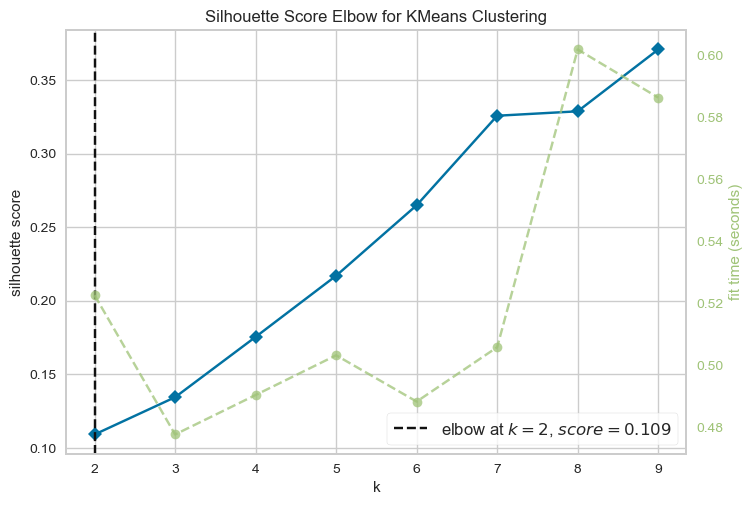

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [113]:
model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

visualizer.fit(X_sample)
visualizer.show() 

In [114]:
silhouette_scores_list = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sample)
    silhouette_avg = silhouette_score(X_sample, cluster_labels)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df

n_clusters  silhouette_score
0           2          0.109131
1           3          0.134449
2           4          0.175426
3           5          0.216997
4           6          0.264868
5           7          0.325684
6           8          0.328691
7           9          0.370705

In [136]:
start_time_kmeans_sample = time.time()

kmeans_sample4 = KMeans(n_clusters=9, n_init=10, random_state=42)
kmeans_sample4.fit(X_sample)

end_time_kmeans_sample = time.time()

execution_time_kmeans_sample = end_time_kmeans_sample - start_time_kmeans_sample
              
labels_sample4 = kmeans_sample4.labels_
centroids_sample4 = kmeans_sample4.cluster_centers_

In [137]:
centroids_df = pd.DataFrame(centroids_sample4, columns=X_sample.columns)

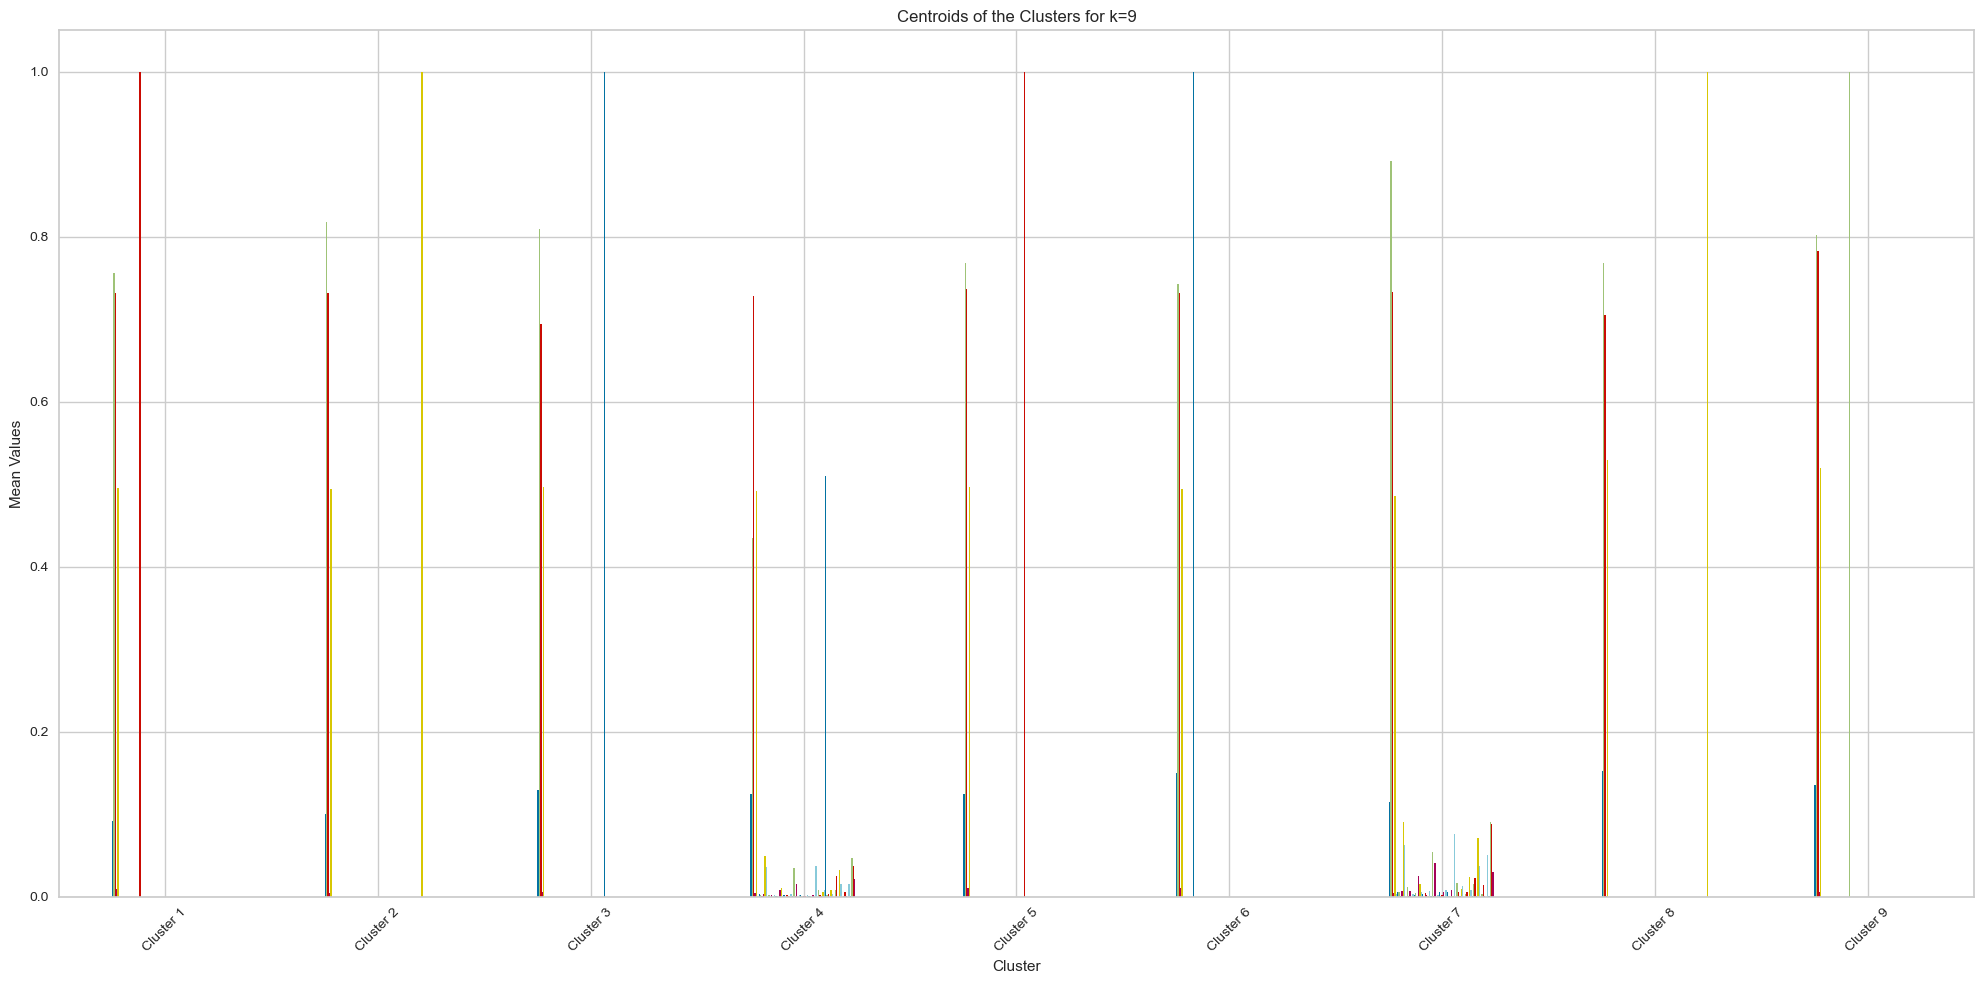

In [140]:
centroids_df.plot(kind='bar', figsize=(20, 10))
plt.title('Centroids of the Clusters for k=9')
plt.ylabel('Mean Values')
plt.xlabel('Cluster')
plt.xticks(np.arange(len(centroids_df)), 
           ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 
            'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9'],
           rotation=45)
plt.legend().remove()
plt.tight_layout()
plt.show()

In [141]:
df_sample_k4= X_sample.assign(cluster_sample4=labels_sample4)

In [142]:
cluster_means_sample4 = df_sample_k4.groupby('cluster_sample4').mean()

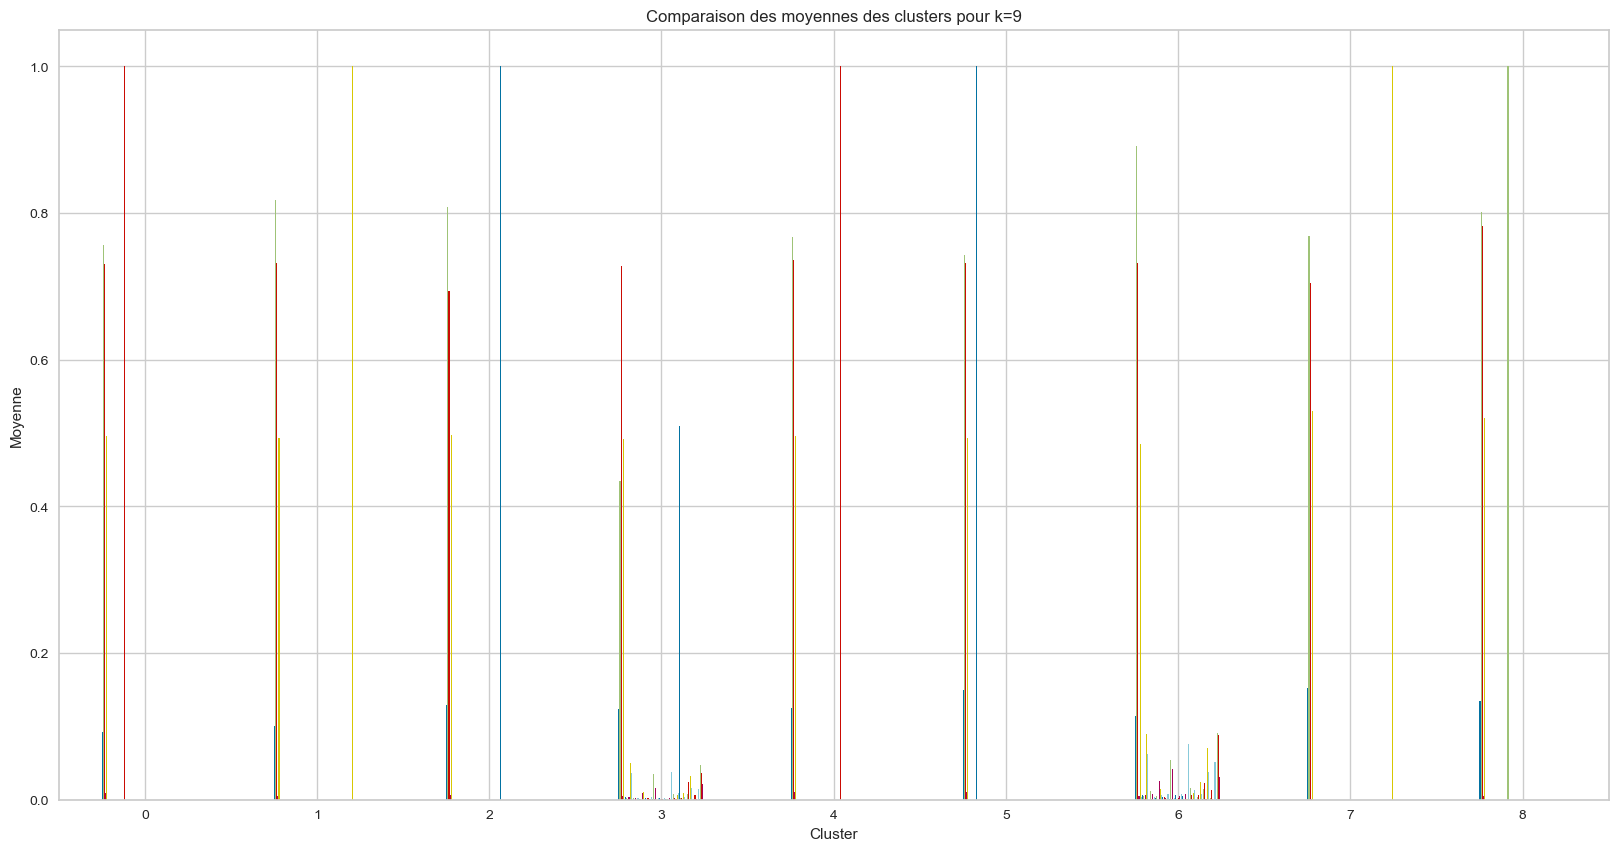

In [143]:
cluster_means_sample4.plot(kind='bar', figsize=(20, 10))
plt.title('Comparaison des moyennes des clusters pour k=9')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend().remove()
plt.show()

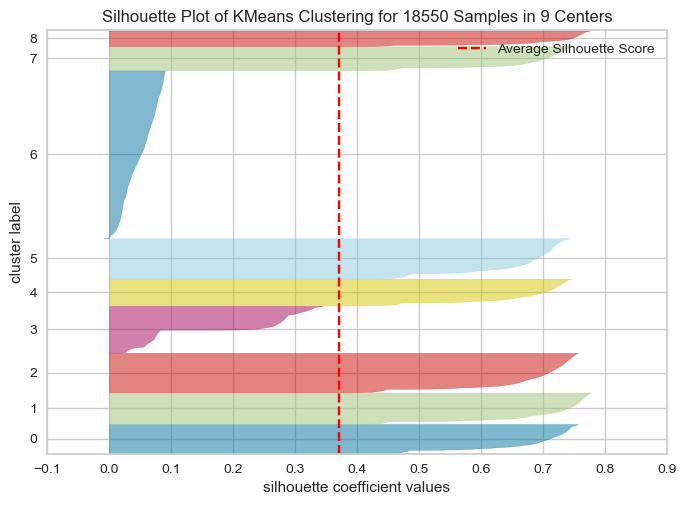

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18550 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [144]:
model = KMeans(9,n_init=10, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_sample)
visualizer.show()

In [146]:
davies_bouldin_sample4 = davies_bouldin_score(X_sample, labels_sample4)
calinski_harabasz_sample4 = calinski_harabasz_score(X_sample, labels_sample4)
silhouette_sample4 = silhouette_score(X_sample, labels_sample4)

In [147]:
scores_df = pd.DataFrame({
    'Method': ['KMeans avec sample9'],
    'Davies-Bouldin': [davies_bouldin_sample4],
    'Calinski-Harabasz': [calinski_harabasz_sample4],
    'Silhouette': [silhouette_sample4],
    'Execution Time (seconds)': [execution_time_kmeans_sample]
})

scores_df

Method  Davies-Bouldin  Calinski-Harabasz  Silhouette  \
0  KMeans avec sample9        1.654153        1988.614746    0.370705   

   Execution Time (seconds)  
0                  0.591856

## Clustering Hiérarchique

In [148]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_sample)
distances, indices = neighbors_fit.kneighbors(X_sample)

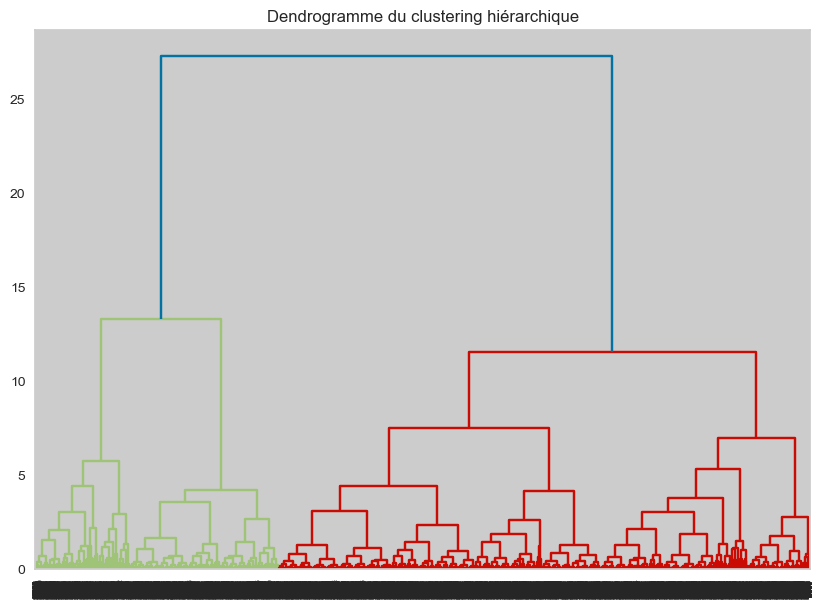

In [149]:
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogramme du clustering hiérarchique')
plt.show()

In [152]:
start_time_sample_ch = time.time()

max_distance = 15
clusters = fcluster(linked, max_distance, criterion='distance')

end_time_sample_ch = time.time()

execution_time_sample_hierarchical = end_time_sample_ch - start_time_sample_ch

X_sample_with_clusters_ch = X_sample.copy()
X_sample_with_clusters_ch['Cluster_Labels'] = clusters

In [151]:
silhouette_scores_list = []

for n_clusters in range(2, 10):
    clusters = fcluster(linked, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(X_sample, clusters)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df_ch = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df_ch

n_clusters  silhouette_score
0           2          0.022999
1           3          0.006736
2           4          0.005885
3           5          0.001757
4           6          0.000723
5           7         -0.000772
6           8         -0.005784
7           9         -0.007562

In [153]:
cluster_means_hierarchical = X_sample_with_clusters_ch.groupby('Cluster_Labels').mean()

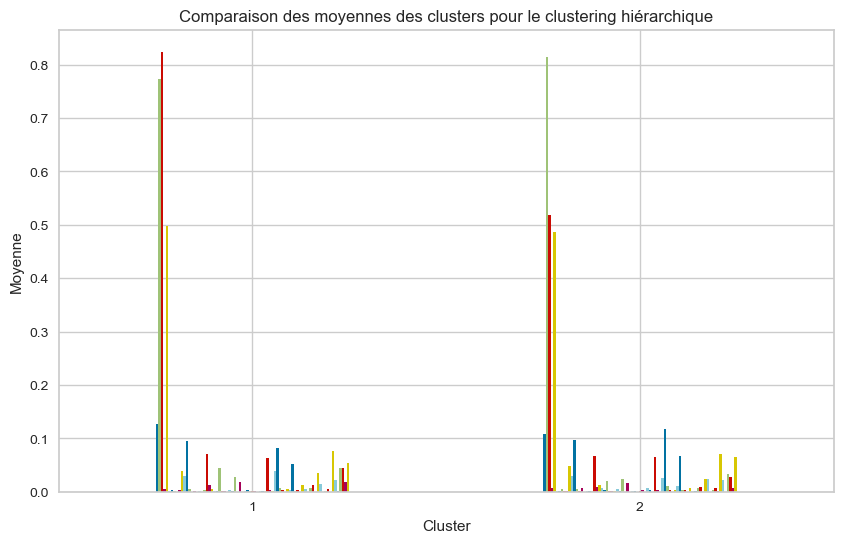

In [154]:
cluster_means_hierarchical.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour le clustering hiérarchique')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend().remove()
plt.show()

In [158]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

hierarchical_labels = fcluster(linked, 2, criterion='maxclust')

tsne_df = pd.DataFrame({'X': X_tsne[:, 0], 'Y': X_tsne[:, 1], 'Cluster': hierarchical_labels})

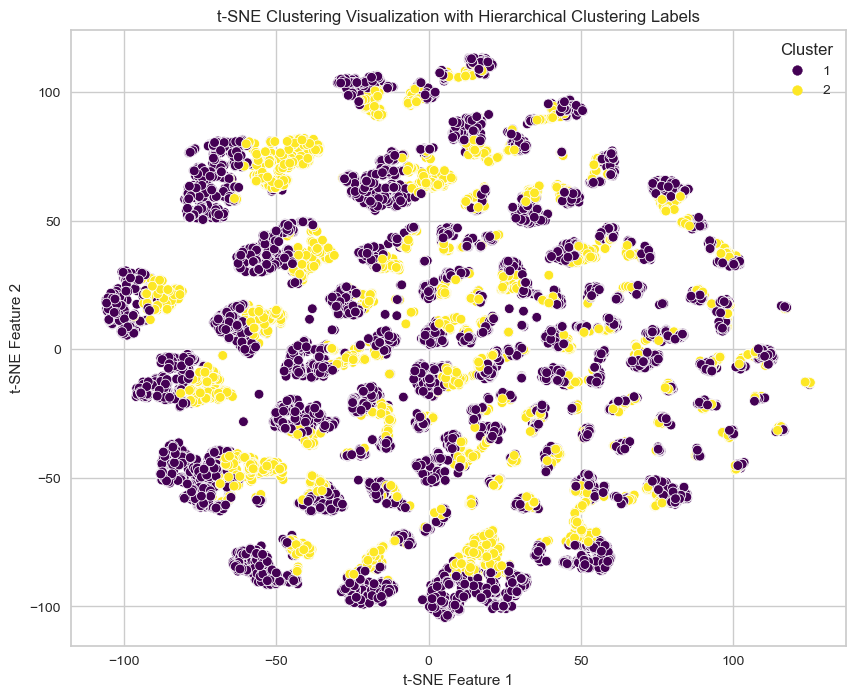

In [159]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=tsne_df, palette='viridis', legend='full')

plt.title('t-SNE Clustering Visualization with Hierarchical Clustering Labels')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

In [160]:
clusters_sample4 = fcluster(linked, 2, criterion='maxclust')

davies_bouldin_hc = davies_bouldin_score(X_sample, clusters_sample4)
calinski_harabasz_hc = calinski_harabasz_score(X_sample, clusters_sample4)
silhouette_hc = silhouette_score(X_sample, clusters_sample4)

scores_hc_df = pd.DataFrame({
    'Method': ['Hierarchical Clustering k4'],
    'Davies-Bouldin': [davies_bouldin_hc],
    'Calinski-Harabasz': [calinski_harabasz_hc],
    'Silhouette': [silhouette_hc],
    'Execution Time (seconds)': [execution_time_rfmsi_hierarchical]
})

scores_hc_df

Method  Davies-Bouldin  Calinski-Harabasz  Silhouette  \
0  Hierarchical Clustering k4        6.588438         364.471938    0.022999   

   Execution Time (seconds)  
0                  0.029314

## DBSCAN

In [161]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_sample)
distances, indices = neighbors_fit.kneighbors(X_sample)

In [162]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

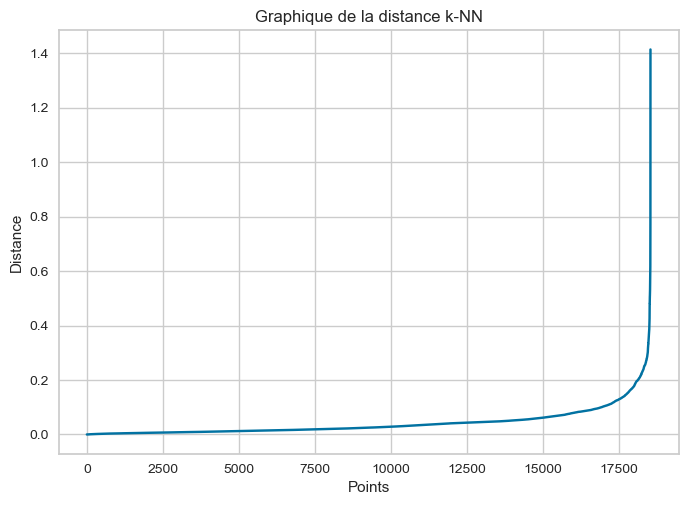

In [163]:
plt.plot(distances)
plt.title('Graphique de la distance k-NN')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.show()

In [164]:
eps = 2500
min_samples = 5

start_time_sample_dbscan = time.time()

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_sample)

end_time_sample_dbscan = time.time()

execution_time_sample_dbscan = end_time_sample_dbscan - start_time_sample_dbscan

In [165]:
mask = clusters != -1
filtered_X = X_sample[mask]
filtered_clusters = clusters[mask]

unique_clusters = len(set(filtered_clusters))
num_noise = sum(clusters == -1)

if unique_clusters > 1:
    davies_bouldin_score_val = davies_bouldin_score(filtered_X, filtered_clusters)
    calinski_harabasz_score_val = calinski_harabasz_score(filtered_X, filtered_clusters)
    silhouette_score_val = silhouette_score(filtered_X, filtered_clusters)
else:
    davies_bouldin_score_val = None
    calinski_harabasz_score_val = None
    silhouette_score_val = None
    print("Le score de silhouette ne peut pas être calculé s'il n'y a qu'un seul cluster ou si tous les points sont considérés comme du bruit")

print(f'Nombre de clusters trouvés par DBSCAN (en excluant le bruit) : {unique_clusters}')
print(f'Nombre de points de bruit : {num_noise}')
print(f'Silhouette Score: {silhouette_score_val}')

Le score de silhouette ne peut pas être calculé s'il n'y a qu'un seul cluster ou si tous les points sont considérés comme du bruit
Nombre de clusters trouvés par DBSCAN (en excluant le bruit) : 1
Nombre de points de bruit : 0
Silhouette Score: None


In [166]:
df_dbscan = X_sample.assign(Cluster_Labels=clusters)

df_dbscan = df_dbscan[df_dbscan['Cluster_Labels'] != -1]

cluster_means_dbscan = df_dbscan.groupby('Cluster_Labels').mean()

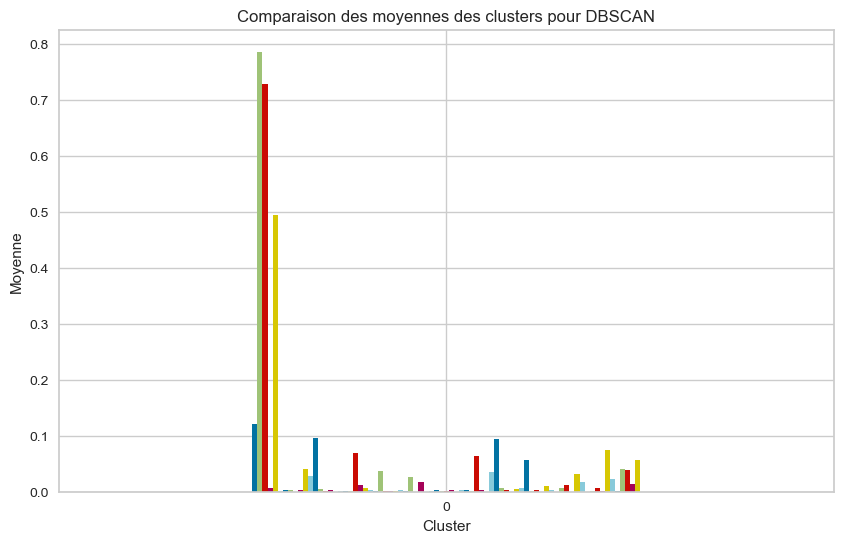

In [167]:
cluster_means_dbscan.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des moyennes des clusters pour DBSCAN')
plt.xlabel('Cluster')
plt.ylabel('Moyenne')
plt.xticks(rotation=0)
plt.legend().remove()
plt.show()

In [168]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)

X_tsne = tsne.fit_transform(X_sample)
tsne_df = pd.DataFrame({
    'X': X_tsne[:, 0],
    'Y': X_tsne[:, 1],
    'Cluster': clusters
})

tsne_df = tsne_df[tsne_df['Cluster'] != -1]

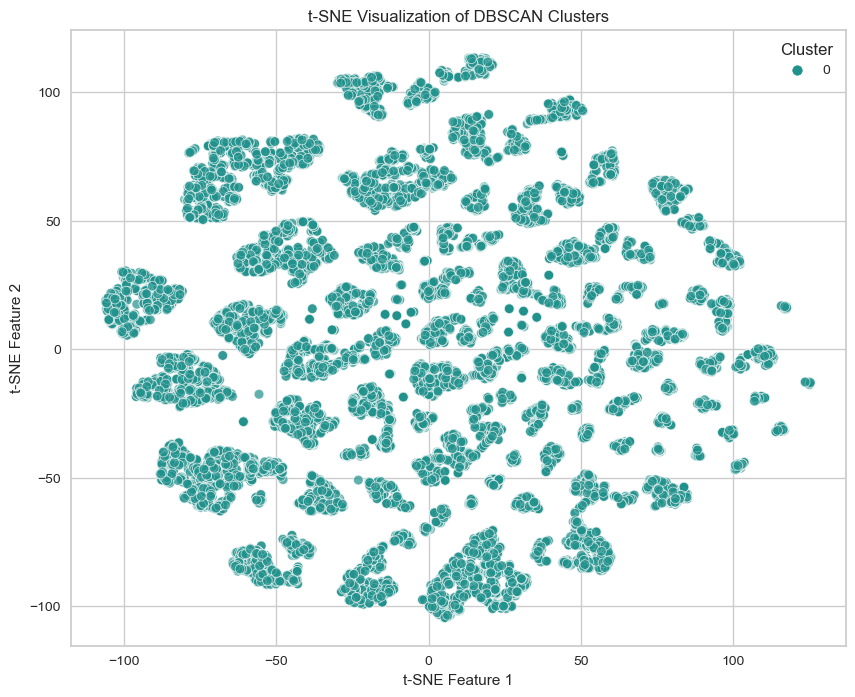

In [169]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=tsne_df, palette='viridis', legend='full', alpha=0.7)

plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()

In [170]:
scores_dbscan_df = pd.DataFrame({
    'Method': ['DBSCAN'],
    'Davies-Bouldin': [davies_bouldin_score_val],
    'Calinski-Harabasz': [calinski_harabasz_score_val],
    'Silhouette': [silhouette_score_val],
    'Execution Time (seconds)': [execution_time_sample_dbscan] 
})

scores_dbscan_df

Method Davies-Bouldin Calinski-Harabasz Silhouette  \
0  DBSCAN           None              None       None   

   Execution Time (seconds)  
0                 36.999068

## Conclusion de l'essai

L'analyse KMeans avec l'ensemble complet de variables a révélé que, bien que le score silhouette soit inférieur à d'autres essais et que la méthode du coude suggère k=2, un k=9 offre le meilleur score silhouette. L'ajout de variables catégorielles comme la catégorie d'achat la plus fréquente enrichit la segmentation en capturant des comportements d'achat variés. Cela augmente la complexité des données, nécessitant une interprétation prudente des clusters pour une application marketing efficace.

Le clustering hiérarchique n'a pas réussi à identifier des segments clairs avec l'ensemble complet de variables, ce qui peut refléter la complexité des données ou nécessiter un ajustement des paramètres de la méthode.

Quant à DBSCAN, l'absence de clusters significatifs suggère que les paramètres par défaut ou la nature des données ne sont pas adaptés à cette méthode.

# Modele et features choisies

In [171]:
X_sample_RFMS2 = X_sample_RFMS.copy()
X_sample_RFMS2

recency  frequency  monetary  average_review_score
0      0.325689        0.0  0.516012                  0.50
1      0.430673        0.0  0.474766                  1.00
2      0.280533        0.0  0.529514                  1.00
3      0.815299        0.0  0.479851                  0.50
4      0.919390        0.0  0.519429                  0.50
...         ...        ...       ...                   ...
18545  0.649752        0.0  0.559185                  0.25
18546  0.954844        0.0  0.508496                  1.00
18547  0.914156        0.0  0.473795                  1.00
18548  0.921105        0.0  0.461417                  1.00
18549  0.686919        0.0  0.449055                  0.00

[18550 rows x 4 columns]

## KMEANS

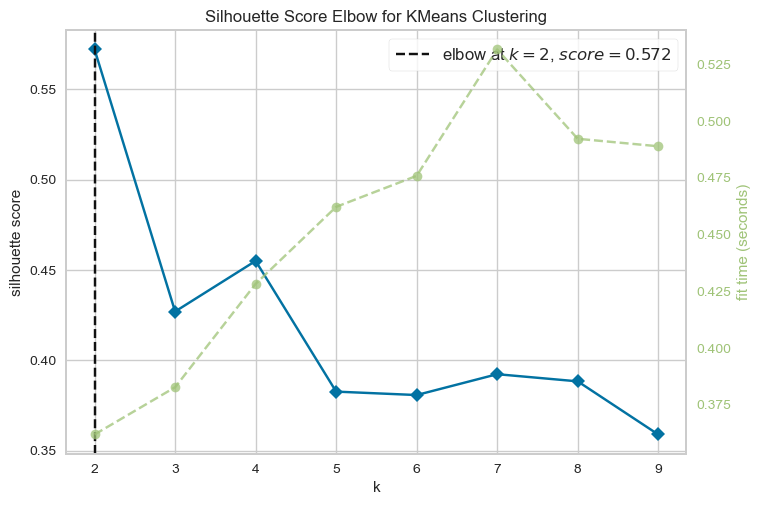

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [172]:
model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

visualizer.fit(X_sample_RFMS2)
visualizer.show() 

In [173]:
silhouette_scores_list = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sample_RFMS2)
    silhouette_avg = silhouette_score(X_sample_RFMS2, cluster_labels)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df

n_clusters  silhouette_score
0           2          0.572001
1           3          0.426946
2           4          0.454959
3           5          0.382613
4           6          0.380716
5           7          0.392255
6           8          0.388294
7           9          0.358890

In [174]:
start_time_kmeans_rfms2 = time.time()

kmeans_k4 = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans_k4.fit(X_sample_RFMS2)

end_time_kmeans_rfms2 = time.time()

execution_time_kmeans_rfms2 = end_time_kmeans_rfms2 - start_time_kmeans_rfms2
              
labels_k4 = kmeans_k4.labels_
centroids_k4 = kmeans_k4.cluster_centers_

In [175]:
centroids_df = pd.DataFrame(centroids_k4, columns=['Recency', 'Frequency', 'Monetary','average_review_score'])

In [176]:
centroids_df

Recency  Frequency  Monetary  average_review_score
0  0.426063   0.007114  0.492606              0.939619
1  0.739671   0.004987  0.507228              0.056750
2  0.783178   0.006186  0.490649              0.668104
3  0.802852   0.005897  0.492212              0.999412

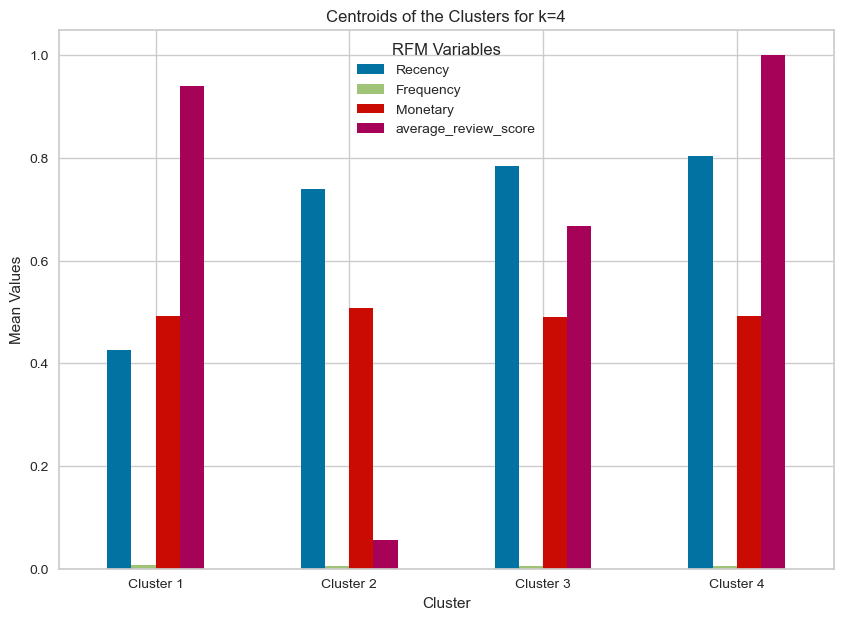

In [177]:
centroids_df.plot(kind='bar', figsize=(10, 7))
plt.title('Centroids of the Clusters for k=4')
plt.ylabel('Mean Values')
plt.xlabel('Cluster')
plt.xticks(np.arange(len(centroids_df)), ['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4'], rotation=0)
plt.legend(title='RFM Variables')
plt.show()

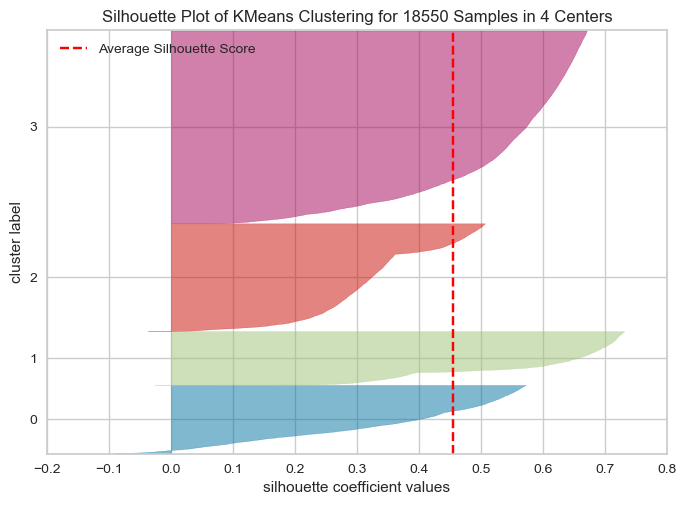

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18550 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [178]:
model = KMeans(4,n_init=10, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_sample_RFMS2)
visualizer.show()

In [179]:
davies_bouldin_k4 = davies_bouldin_score(X_sample_RFMS2, labels_k4)
calinski_harabasz_k4 = calinski_harabasz_score(X_sample_RFMS2, labels_k4)
silhouette_k4 = silhouette_score(X_sample_RFMS2, labels_k4)

In [180]:
scores_df = pd.DataFrame({
    'Method': ['KMeans avec k4'],
    'Davies-Bouldin': [davies_bouldin_k4],
    'Calinski-Harabasz': [calinski_harabasz_k4],
    'Silhouette': [silhouette_k4],
    'Execution Time (seconds)': [execution_time_kmeans_rfms2]
})

scores_df

Method  Davies-Bouldin  Calinski-Harabasz  Silhouette  \
0  KMeans avec k4        0.798899       23672.129721    0.454959   

   Execution Time (seconds)  
0                  0.410159

## Conclusion

Après une évaluation approfondie des différentes méthodes de segmentation et des ensembles de variables, nous avons décidé de continuer avec le modèle KMeans en utilisant les variables RFM et Average Score Review. KMeans s'est avéré être un outil robuste et efficace, offrant plusieurs avantages clés pour notre analyse. Il est particulièrement adapté pour gérer de grands ensembles de données, garantissant une convergence rapide et une implémentation simple. De plus, KMeans permet une interprétation intuitive des clusters, ce qui est essentiel pour l'application des insights dans des stratégies métiers concrètes.

Les métriques de performance, telles que le score silhouette, ont indiqué que quatre clusters constituent le nombre optimal pour une segmentation significative et gérable avec des résultats très acceptables.  

En regroupant les clients en quatre segments distincts, nous pouvons examiner de manière approfondie les caractéristiques et les comportements de chaque groupe, ce qui facilite l'élaboration de stratégies marketing ciblées et l'amélioration de l'expérience client. En fin de compte, cette décision stratégique nous permet de tirer le meilleur parti de nos données tout en restant alignés avec nos objectifs commerciaux.

## Aplication sur l'ensemble du jeu de données 

In [181]:
X_kmeans = X[['average_review_score', 'recency', 'frequency', 'monetary']].copy()

In [182]:
X_kmeans

average_review_score  recency  frequency  monetary
0                      0.75      1.0        0.0  0.386977
1                      0.50      1.0        0.0  0.419700
2                      0.00      1.0        0.0  0.514191
3                      1.00      1.0        0.0  0.391745
4                      1.00      1.0        0.0  0.529521
...                     ...      ...        ...       ...
92749                  0.00      0.0        0.0  0.451553
92750                  1.00      0.0        0.0  0.654738
92751                  1.00      0.0        0.0  0.433302
92752                  0.50      0.0        0.0  0.370365
92753                  1.00      0.0        0.0  0.477395

[92754 rows x 4 columns]

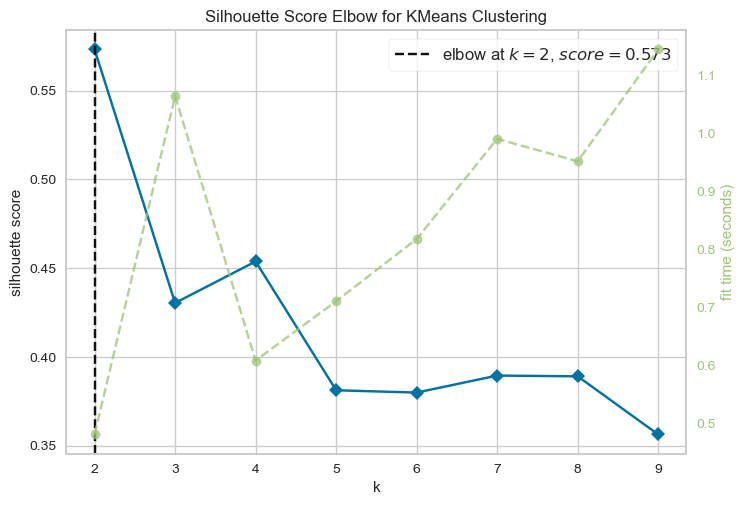

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [183]:
model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

visualizer.fit(X_kmeans)
visualizer.show() 

In [184]:
silhouette_scores_list = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_kmeans)
    silhouette_avg = silhouette_score(X_kmeans, cluster_labels)
    silhouette_scores_list.append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg
    })

silhouette_scores_df = pd.DataFrame(silhouette_scores_list)
silhouette_scores_df

n_clusters  silhouette_score
0           2          0.573196
1           3          0.430350
2           4          0.453744
3           5          0.381152
4           6          0.379859
5           7          0.389435
6           8          0.389013
7           9          0.356244

In [185]:
start_time_kmeans_rfms_final = time.time()

kmeans_k4_final = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans_k4_final.fit(X_kmeans)

end_time_kmeans_rfms_final = time.time()

execution_time_kmeans_rfms_final = end_time_kmeans_rfms_final - start_time_kmeans_rfms_final
              
labels_k_final = kmeans_k4_final.labels_
centroids_k_final = kmeans_k4_final.cluster_centers_

In [186]:
centroids_df = pd.DataFrame(centroids_k_final, columns=['Recency', 'Frequency', 'Monetary','average_review_score'])

In [187]:
centroids_df

Recency  Frequency  Monetary  average_review_score
0  0.999357   0.803996  0.006216              0.490039
1  0.060625   0.737829  0.003728              0.504877
2  0.668293   0.784160  0.006905              0.490740
3  0.940030   0.428306  0.007560              0.493285

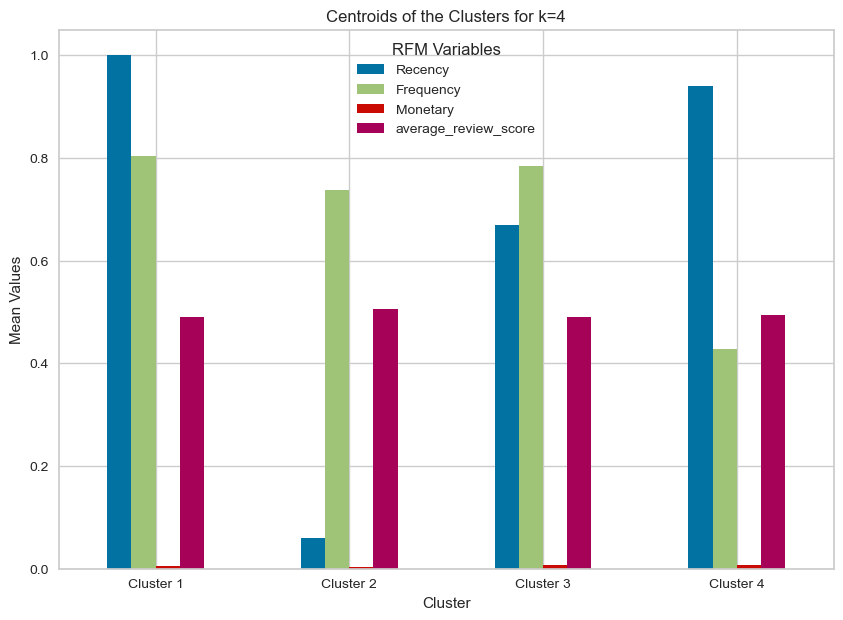

In [188]:
centroids_df.plot(kind='bar', figsize=(10, 7))
plt.title('Centroids of the Clusters for k=4')
plt.ylabel('Mean Values')
plt.xlabel('Cluster')
plt.xticks(np.arange(len(centroids_df)), ['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4'], rotation=0)
plt.legend(title='RFM Variables')
plt.show()

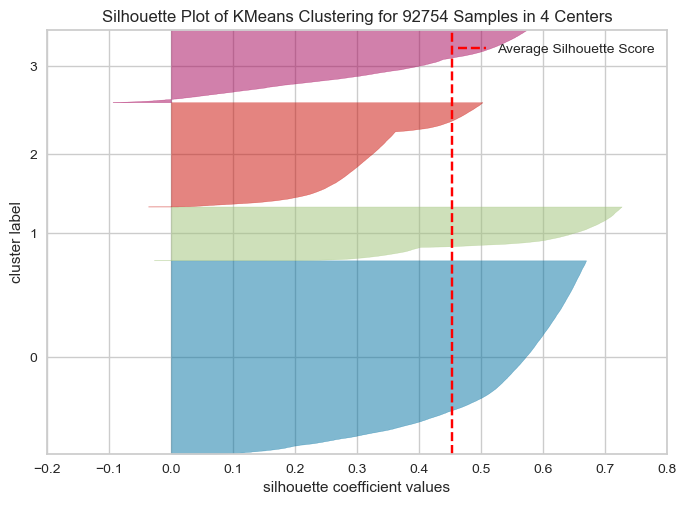

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 92754 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [189]:
model = KMeans(4,n_init=10, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_kmeans)
visualizer.show()

In [190]:
df_analyse['cluster'] = labels_k_final

In [191]:
# Statistiques descriptives du cluster 0
cluster_number = 0
cluster_data = df_analyse[df_analyse['cluster'] == cluster_number]
cluster_0 = cluster_data.describe()
cluster_0

average_installments  average_review_score       recency     frequency  \
count          42366.000000          42366.000000  42366.000000  42366.000000   
mean               2.899308              4.997427    294.470590      1.032904   
std                2.686393              0.035788    132.135521      0.199618   
min                0.000000              4.333333    101.000000      1.000000   
25%                1.000000              5.000000    184.000000      1.000000   
50%                2.000000              5.000000    277.000000      1.000000   
75%                4.000000              5.000000    392.000000      1.000000   
max               24.000000              5.000000    699.000000      7.000000   

           monetary  cluster  
count  42366.000000  42366.0  
mean     157.689882      0.0  
std      213.047283      0.0  
min        0.010000      0.0  
25%       59.805000      0.0  
50%      103.150000      0.0  
75%      175.035000      0.0  
max     7571.630000      0.0

**Cluster 1 : Clients occasionnels satisfaits**  

Average Installments: Les clients de ce cluster ont tendance à choisir un nombre moyen de paiements échelonnés (environ 2,9), avec une certaine variabilité (écart-type d'environ 2,7).  

Average Review Score: Ces clients sont très satisfaits, comme en témoigne leur score moyen de presque 5 sur 5, avec très peu de variation.  

Recency: Ils ont effectué des achats relativement récemment, avec une moyenne de 294 jours depuis le dernier achat, mais avec une plage allant de 101 à 699 jours.  

Frequency: La fréquence d'achat est faible, la plupart ayant effectué un seul achat (médiane de 1), bien que certains aient effectué jusqu'à 7 achats.   

Monetary: Le montant moyen dépensé est modeste, mais avec une grande variabilité.

In [193]:
#Statistiques descriptives du cluster 1

cluster_number = 1
cluster_data = df_analyse[df_analyse['cluster'] == cluster_number]
cluster_1 = cluster_data.describe()
cluster_1

average_installments  average_review_score       recency     frequency  \
count          11792.000000          11792.000000  11792.000000  11792.000000   
mean               3.145169              1.242502    240.376018      1.019505   
std                2.889842              0.429554    141.191448      0.147783   
min                1.000000              1.000000      4.000000      1.000000   
25%                1.000000              1.000000    143.000000      1.000000   
50%                2.000000              1.000000    215.000000      1.000000   
75%                4.000000              1.000000    317.000000      1.000000   
max               24.000000              2.500000    699.000000      4.000000   

           monetary  cluster  
count  11792.000000  11792.0  
mean     187.981610      1.0  
std      286.300922      0.0  
min        0.280000      1.0  
25%       67.287500      1.0  
50%      117.985000      1.0  
75%      203.422500      1.0  
max    13664.080000      1.0

**Cluster 2: Clients perdus/à reconquérir**  

Average Installments: Ils choisissent un nombre légèrement supérieur de paiements échelonnés par rapport au cluster précédent, avec une moyenne d'environ 3,1 et une variabilité similaire.  

Average Review Score: Le score moyen de satisfaction est très bas, à 1,24, indiquant un niveau de mécontentement notable parmi ces clients.  

Recency: Ils ont effectué des achats plus récemment que le cluster précédent, avec une moyenne de 240 jours depuis le dernier achat.  

Frequency: La fréquence d'achat est similaire au cluster précédent, avec la plupart des clients ayant effectué un seul achat.  

Monetary: Le montant moyen dépensé est légèrement plus élevé que dans le cluster précédent, avec une moyenne d'environ 188 unités monétaires, et une grande variabilité.

In [195]:
#Statistiques descriptives du cluster 2

cluster_number = 2
cluster_data = df_analyse[df_analyse['cluster'] == cluster_number]
cluster_2 = cluster_data.describe()
cluster_2

average_installments  average_review_score       recency     frequency  \
count          22831.000000          22831.000000  22831.000000  22831.000000   
mean               2.866212              3.673157    276.909553      1.036529   
std                2.645496              0.469508    138.457440      0.212151   
min                1.000000              2.500000     31.000000      1.000000   
25%                1.000000              3.000000    165.000000      1.000000   
50%                2.000000              4.000000    262.000000      1.000000   
75%                4.000000              4.000000    377.000000      1.000000   
max               24.000000              4.333333    699.000000      9.000000   

           monetary  cluster  
count  22831.000000  22831.0  
mean     156.689787      2.0  
std      199.891064      0.0  
min        0.010000      2.0  
25%       60.750000      2.0  
50%      103.860000      2.0  
75%      175.850000      2.0  
max     4764.340000      2.0

**Cluster 3 : Clients potentiels**  

Average Installments: Ils ont une tendance similaire aux autres clusters en termes de paiements échelonnés, avec une moyenne d'environ 2,9.  

Average Review Score: Le score de satisfaction moyen est modéré, à 3,67, ce qui suggère un niveau de satisfaction ni très élevé ni très bas.  

Recency: Ces clients ont effectué des achats dans un passé relativement récent, avec une moyenne de 277 jours depuis le dernier achat.  

Frequency: La fréquence d'achat est légèrement supérieure à un achat, ce qui indique que la plupart des clients ont effectué un seul achat, mais certains ont acheté plus fréquemment.  

Monetary: Le montant moyen dépensé est comparable à celui des autres clusters.

In [197]:
##Statistiques descriptives du cluster 3

cluster_number = 3
cluster_data = df_analyse[df_analyse['cluster'] == cluster_number]
cluster_3 = cluster_data.describe()
cluster_3

average_installments  average_review_score       recency     frequency  \
count          15765.000000           15765.00000  15765.000000  15765.000000   
mean               2.761220               4.75986     48.171709      1.041421   
std                2.553017               0.48158     25.932776      0.263671   
min                1.000000               2.50000      4.000000      1.000000   
25%                1.000000               5.00000     26.000000      1.000000   
50%                1.000000               5.00000     44.000000      1.000000   
75%                4.000000               5.00000     70.000000      1.000000   
max               20.000000               5.00000    113.000000     15.000000   

           monetary  cluster  
count  15765.000000  15765.0  
mean     163.381636      3.0  
std      223.672773      0.0  
min        0.010000      3.0  
25%       61.400000      3.0  
50%      107.850000      3.0  
75%      180.460000      3.0  
max     4681.780000      3.0

**Cluster 4 : Clients Ambassadeurs**  

Average Installments: Les clients de ce cluster ont tendance à choisir un nombre légèrement inférieur de paiements échelonnés, avec une moyenne d'environ 2,76.  

Average Review Score: Ils présentent un niveau de satisfaction élevé, avec un score moyen proche de 4,76, ce qui indique que la majorité des clients sont très satisfaits de leurs achats.  

Recency: Ce qui distingue particulièrement ce cluster est la récence des achats, avec une moyenne de seulement 48 jours depuis le dernier achat, ce qui suggère que ces clients ont effectué des achats très récemment.  

Frequency: La fréquence d'achat est similaire aux autres clusters, avec la plupart des clients ayant effectué un seul achat, mais il y a une légère augmentation de la fréquence pour certains.  

Monetary: Le montant moyen dépensé est légèrement plus élevé que dans les autres clusters, avec une moyenne d'environ 163 unités monétaires et une variabilité significative.  

In [199]:
cluster_names = {
    0: 'Clients Occasionnels Satisfaits',
    1: 'Clients Perdus/À Reconquérir',
    2: 'Clients Potentiels',
    3: 'Clients Ambassadeurs'
}

df_analyse['cluster_name'] = df_analyse['cluster'].map(cluster_names)

In [201]:
df_analyse.head()

order_purchase_timestamp                customer_unique_id  \
0      2016-10-03 16:56:50  2f64e403852e6893ae37485d5fcacdaf   
1      2016-10-03 21:13:36  61db744d2f835035a5625b59350c6b63   
2      2016-10-03 22:06:03  8d3a54507421dbd2ce0a1d58046826e0   
3      2016-10-03 22:31:31  87776adb449c551e74c13fc34f036105   
4      2016-10-03 22:44:10  7390ed59fa1febbfda31a80b4318c8cb   

   average_installments  average_review_score  recency  frequency  monetary  \
0                   1.0                   4.0      699          1     39.09   
1                   1.0                   3.0      699          1     53.73   
2                   6.0                   1.0      699          1    133.46   
3                   4.0                   5.0      699          1     40.95   
4                   2.0                   5.0      699          1    154.57   

  most_frequent_payment_type most_frequent_category  cluster  \
0                     boleto         sports_leisure        2   
1                     boleto         sports_leisure        2   
2                credit_card        furniture_decor        1   
3                credit_card          fashion_shoes        0   
4                credit_card                   toys        0   

                      cluster_name  
0               Clients Potentiels  
1               Clients Potentiels  
2     Clients Perdus/À Reconquérir  
3  Clients Occasionnels Satisfaits  
4  Clients Occasionnels Satisfaits

Fin de la partie essaie